In [ ]:
'''Welcome to my submission for the first assignment in the Udacity 
Data Scientist Nanodegree: Write a Data Science Blog Post.

In this notebook I'll try to synthesize everything I've learned from my courses so far, 
using a dataset that I acquired myself, and even did most of the gathering for:
The data gathered by monitoring the growth and health of over 30,000 plants
seeded by an ecological restoration effort near Bogotá, Colombia across 5 geographically
distinct locations. For contractual reasons, I'll have to anonymize the exact
names and locations of the project, but rest assured, this is all real, 
on-the-ground data. Only a lunatic would make all of this up.

Please run cells sequentially.

'''

In [ ]:
'''Step 1: Business Understanding.
The fundamental goal of Ecological Restoration is to sow the seeds 
(figuratively and sometimes literally)
that take a geographic area from some sort of disturbance to a new,
balanced and functioning ecosystem.

In this case the ecological disturbance was caused by logging and extensive agriculture or industry,
the target for restoration is to replace these fields with something equivalent to 
the local ecosystem: Either Andean forest, or Páramo, depending on the local altitude.

To do this, we have chosen to assist the natural regeneration of native species, 
by sowing various species found in the adjacent forest and páramo in a few designs of
Nuclei: smaller grouped lots of varied species. This differs from a standard row planting
because it allows plants to take advantage of each other for cover, and is less expensive
for the same amount of area. It also mimics how plants tend to naturally colonize landscapes.
(See figure 1 for an example)

So now that we have everything planted, we must ask the following questions: 
    Mechanically:
        Is the process working? 
        Are the plants growing properly? 
        Are they surviving? 
        Are they healthy? Why or why not?
    
    Ecologically:
        Do we have a good representation of species? 
        Is there evidence of interactions or conflict with local species? 
        How are these interactions affecting our metrics?
    
    Logistically:
        What variables can we control to improve our outcomes? 
        How can we do that?
    
Note: The Udacity project specifies 3-5 questions. Some of these are fairly simple to answer so
I'm choosing to take those three categories as compound questions to answer.
'''
# To do: Include an example picture of module layout as figure 1

In [ ]:
'''Step 2: Data Understanding.
The dataset covers 5 geographic areas, some of which are split based on various
ecological or organizational criteria, for a total of 9 excel files. Additionally,
we have separate tables containing the geographic coordinates of each Nucleus,
and a much dirtier dataset containing information about the origins of the plant material
from the nursery it came from.

In theory, these files should all have the same structure, column headings,
formatting, and have already been cleaned. 
A quick look at the files would show this is not the case.

'''

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

In [2]:
# Open and read all of the excel files. I have renamed these from the business'
# Actual filenames for ease of use and anonymity.

# First get the filenames from the directory
from os import walk
filenames = set()
for root, folders, files in walk('Original Data'):#Might not need the three levels
    for name in files:
        filenames.add(name)
        



In [254]:
# Next actually get the data
# Create a dictionary of the lists.
df_dict = {}
# Assign data to dictionary
for name in filenames:
    text = name.replace('.xlsx', '')
    directory = f"Original Data\{name}"
    try:
        df_dict[text] = pd.read_excel(directory, engine='openpyxl') 
        #In Spanish using read_excel allows for easier unicode parsing of special characters like 'ñ'
    except:
        continue
# This used to throw an error whenever excel left a temp file in the directory.
# Solved using try/except
# This is inefficient, can probably modularize depending on which dataset you want to work with rather than opening all of them.


In [255]:
# Some basic parameters of the data
for df in df_dict:
    print (df, df_dict[df].shape)
    
df_dict['reserve'].head()

Santa Rosa (10980, 31)
Banqueo_Forest (2000, 27)
Bojaca_Veda500-675 (2200, 26)
Coordinates (54, 7)
Bojaca_Veda500-766 (50, 25)
Banqueo_Disturbed (3505, 27)
Reserve (16506, 32)
Esmeralda (11943, 28)
Bojaca_Veda230 (2417, 24)
Peñas (6588, 28)


,Fecha,ID,Even_mon,Especie,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,...,Herbivoria,Patogenos,Competencia,Daño mecanico,Anegamiento,Planta no encontrada,Daño por Curi,Rebrotando,Observaciones_Sup,Period planted
0,2019-12-01 00:00:00,1,T1,Ceroxylon alpinum,1,1,39,0.0,0.0,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
1,2019-12-01 00:00:00,2,T1,Ceroxylon alpinum,1,2,52,0.0,0.0,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
2,2019-12-01 00:00:00,3,T1,Ceroxylon alpinum,1,3,66,0.0,0.0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
3,2019-12-01 00:00:00,4,T1,Ceroxylon alpinum,1,4,66,0.0,0.0,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1
4,2019-12-01 00:00:00,5,T1,Ceroxylon alpinum,1,5,46,0.0,0.0,46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T1


In [5]:
'''Clearly the data needs some cleaning. Looking at the sets also shows a lot of NaN values.
I know this from working with the data personally, but this is normal. The dataset is split into
categorical and context data (date, Even_mon, Especie, No_Mod), quantifiable data like
height (Alt_prom), stem diameter (DAB_prom), health (Est_Fit_Ind), and boolean data indicating survival
the affliction of the plant (Coloracion, Vigor Bajo). This data was taken in spanish so while
I will provide translation when necessary, please bear with me with everything else if the
column names don't make any sense.
''' 

"Clearly the data needs some cleaning. Looking at the sets also shows a lot of NaN values.\nI know this from working with the data personally, but this is normal. The dataset is split into\ncategorical and context data (date, Even_mon, Especie, No_Mod), quantifiable data like\nheight (Alt_prom), stem diameter (DAB_prom), health (Est_Fit_Ind), and boolean data indicating survival\nthe affliction of the plant (Coloracion, Vigor Bajo). This data was taken in spanish so while\nI will provide translation when necessary, please bear with me with everything else if the\ncolumn names don't make any sense.\n"

In [6]:
'''Step 3: Data Preparation
For the purposes of this analysis I will focus on a single one, which I will call
"reserve", as it is the oldest and has the most data. 
Since each scenario is in a geographically distinct location, comparing between them
is difficult, and it would make sense to instead modularize the analysis and apply 
it repeatedly to each scenario.
'''

'Step 3: Data Preparation\nFor the purposes of this analysis I will focus on a single one, which I will call\n"Reserve", as it is the oldest and has the most data. \nSince each scenario is in a geographically distinct location, comparing between them\nis difficult, and it would make sense to instead modularize the analysis and apply \nit repeatedly to each scenario.\n'

In [256]:
# Select the relevant datasets
reserve = df_dict['reserve']
coords = df_dict['Coordinates']

In [257]:
# Looking at the dataset, we shouldn't have any object classes.
print(reserve.dtypes)

Fecha                    object
ID                        int64
Even_mon                 object
Especie                  object
No_Mod                    int64
No_Ind                    int64
Alt1_Ind                 object
Alt2_Ind                float64
Alt3_Ind                float64
Alt_Ind Promedio         object
DAB1_Ind                 object
DAB2_Ind                float64
DAB3_Ind                 object
DAB_prom                 object
Diam_1_Ind              float64
Diam_2_Ind              float64
Area_cop_ind            float64
Observaciones_Crec       object
Sup_Ind                  object
Est_Fit_Ind             float64
Coloracion               object
Vigor bajo               object
Herbivoria               object
Patogenos                object
Competencia              object
Daño mecanico            object
Anegamiento              object
Planta no encontrada     object
Daño por Curi            object
Rebrotando               object
Observaciones_Sup        object
Period p

In [258]:
# Convert data types
reserve = reserve.convert_dtypes() #This only does half of the columns
reserve = reserve.astype(float, errors='ignore')
reserve = reserve._convert(numeric=True)
# To do: Good chance we can turn this into a function for every dataset

In [259]:
reserve.dtypes #Much better, we can change Fecha after some examination.

Fecha                    object
ID                      float64
Even_mon                 string
Especie                  string
No_Mod                  float64
No_Ind                  float64
Alt1_Ind                float64
Alt2_Ind                float64
Alt3_Ind                float64
Alt_Ind Promedio        float64
DAB1_Ind                float64
DAB2_Ind                float64
DAB3_Ind                float64
DAB_prom                float64
Diam_1_Ind              float64
Diam_2_Ind              float64
Area_cop_ind            float64
Observaciones_Crec       string
Sup_Ind                  string
Est_Fit_Ind             float64
Coloracion               string
Vigor bajo               string
Herbivoria               string
Patogenos                string
Competencia              string
Daño mecanico            string
Anegamiento              string
Planta no encontrada     string
Daño por Curi            string
Rebrotando               string
Observaciones_Sup        string
Period p

In [260]:
coords.head()

,Pastos 1,Pastos 2,Fajas 1,Fajas 2,Fajas 3,Bosque,Vegetacion
0,2.0,2.0,1.0,2.0,2.0,1,1.0
1,4.0,4.0,3.0,3.0,3.0,3,3.0
2,8.0,7.0,4.0,4.0,6.0,5,5.0
3,9.0,8.0,5.0,6.0,7.0,7,7.0
4,11.0,9.0,8.0,8.0,10.0,9,9.0


In [261]:
# It turns out that the coordinate data is in a different format than the rest of the data
# and is split into worksheets.

coords = pd.read_excel('Original Data\Coordinates.xlsx', 'reserve')
coords.head()

,NOMBRE,ID_MUEST,COOR_ESTE,COOR_NORTE
0,Comp. Aprov Forestal - Arreglo 1,CAF-N1-1,-73.910047,4.793035
1,Comp. Aprov Forestal - Arreglo 1,CAF-N1-2,-73.910047,4.793082
2,Comp. Aprov Forestal - Arreglo 1,CAF-N1-3,-73.910006,4.793059
3,Comp. Aprov Forestal - Arreglo 1,CAF-N1-4,-73.910006,4.793011
4,Comp. Aprov Forestal - Arreglo 1,CAF-N1-5,-73.910047,4.792988


In [262]:
# Now each plant is given a unique identifier in the dataset
reserve['ID'].unique().max() #It's 2751

# This is exactly 1/6 of the length of the set, we can conclude that each of the same plant was measured 6 times.
# This is corroborated by the unique monitoring events 'Even_mon' as well as unique dates 'Fecha'
# Though the date apparently has some formatting issues.
print(reserve['Even_mon'].unique())
print(reserve['Fecha'].unique())

<StringArray>
['T1', 'T2', 'T3', 'T4', 'T5', 'T6']
Length: 6, dtype: string
[datetime.datetime(2019, 12, 1, 0, 0) datetime.datetime(2020, 4, 1, 0, 0)
 datetime.datetime(2020, 7, 1, 0, 0) datetime.datetime(2020, 10, 1, 0, 0)
 '23/3/2021' datetime.datetime(2021, 7, 6, 0, 0)]


In [263]:
# So now we can format Fecha as datetime
reserve['Fecha'] = pd.to_datetime(reserve['Fecha'])
print(reserve['Fecha'].unique())

['2019-12-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000'
 '2020-07-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2021-03-23T00:00:00.000000000' '2021-07-06T00:00:00.000000000']


In [264]:
# The coordinate data only has resolution down to the sub-Nucleus level, not the individual.
# Luckily the dataset also assigns an identifier to the nucleus: No_Mod
print(reserve['No_Mod'].unique())

# Similarly the coordinate data also includes this under 'ID_MUEST'
print(coords['ID_MUEST'])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57.]
0      CAF-N1-1
1      CAF-N1-2
2      CAF-N1-3
3      CAF-N1-4
4      CAF-N1-5
         ...   
465      CAF-T9
466      CAF-T8
467      CAF-T6
468      CAF-T5
469      CAF-T7
Name: ID_MUEST, Length: 470, dtype: object


In [265]:
# However, Looking at the coordinate data shows that it has a lot of other data that is unrelated.
print(coords['NOMBRE'].unique())

['Comp. Aprov Forestal - Arreglo 1' 'Comp. Aprov Forestal - Arreglo 2'
 'Comp. Aprov Forestal - Arreglo 3' 'Comp. Aprov Forestal - Arreglo 4'
 'Comp. Aprov Forestal - Arreglo 5' 'Comp. Aprov Forestal - Arreglo 6'
 'Comp. Aprov Forestal - Arreglo 7' 'Comp. Aprov Forestal - Arreglo 8'
 'Comp. Aprov Forestal - Arreglo 9' 'Comp. Aprov Forestal - Arreglo 10'
 'Comp. Aprov Forestal - Arreglo 11' 'Comp. Aprov Forestal - Arreglo 12'
 'Comp. Aprov Forestal - Arreglo 13' 'Comp. Aprov Forestal - Arreglo 14'
 'Comp. Aprov Forestal - Arreglo 15' 'Comp. Aprov Forestal - Arreglo 16'
 'Comp. Aprov Forestal - Arreglo 17' 'Comp. Aprov Forestal - Arreglo 18'
 'Comp. Aprov Forestal - Arreglo 19' 'Comp. Aprov Forestal - Arreglo 20'
 'Comp. Aprov Forestal - Arreglo 21' 'Comp. Aprov Forestal - Arreglo 22'
 'Comp. Aprov Forestal - Arreglo 23' 'Comp. Aprov Forestal - Arreglo 24'
 'Comp. Aprov Forestal - Arreglo 25' 'Comp. Aprov Forestal - Arreglo 26'
 'Comp. Aprov Forestal - Arreglo 27' 'Comp. Aprov Forestal -

In [266]:
# This refers to other scientific study data that is relevant to the project, but not to this analysis.
# We only want the data that contains the word "Arreglo" in the name, Spanish for "Arrangement"
select_coords = coords[coords['NOMBRE'].str.contains('Arreglo')]

# We now have 7 coordinates for each Nucleus, so we need to average
# First by creating a new column attaching the nucleus number to each type
# We can get that directly from the 'ID_MUEST' column by applying some slicing:
nucs = select_coords['ID_MUEST'].str[5:-2]

select_coords['No_Mod'] = nucs #This way it has the same column name as the reserve dataset
# Pandas drops a warning here but since we're not modifying the data anywhere in between we can ignore it.
select_coords.head()
# To do: We can probably save memory by doing this in a function.

C:\Users\Felipe\AppData\Local\Temp/ipykernel_11840/1126619261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_coords['No_Mod'] = nucs #This way it has the same column name as the Reserve dataset


,NOMBRE,ID_MUEST,COOR_ESTE,COOR_NORTE,No_Mod
0,Comp. Aprov Forestal - Arreglo 1,CAF-N1-1,-73.910047,4.793035,1
1,Comp. Aprov Forestal - Arreglo 1,CAF-N1-2,-73.910047,4.793082,1
2,Comp. Aprov Forestal - Arreglo 1,CAF-N1-3,-73.910006,4.793059,1
3,Comp. Aprov Forestal - Arreglo 1,CAF-N1-4,-73.910006,4.793011,1
4,Comp. Aprov Forestal - Arreglo 1,CAF-N1-5,-73.910047,4.792988,1


In [267]:
# Now we can average the coordinates
mask = select_coords.groupby(['No_Mod']).mean()
# Without these next 2 lines joining the tables throws a type error
mask.reset_index(level=0, inplace=True) 
mask['No_Mod'] = mask['No_Mod'].astype('int64')
mask
# To do: We can probably save memory by doing this in a function.

,No_Mod,COOR_ESTE,COOR_NORTE
0,1,-73.910047,4.793035
1,10,-73.909950,4.792362
2,11,-73.909673,4.792434
3,12,-73.909547,4.792267
4,13,-73.909824,4.792175
5,14,-73.909731,4.791990
6,15,-73.909486,4.791552
7,16,-73.909415,4.791411
8,17,-73.909428,4.791240
9,18,-73.909707,4.790889


In [268]:
# Now we can finally merge the data
reserve = reserve.merge(mask, how='outer', on='No_Mod')
# To do: We can probably save memory by doing this in a function.


reserve[['ID', 'COOR_ESTE', 'COOR_NORTE']].head()


,ID,COOR_ESTE,COOR_NORTE
0,1.0,-73.910047,4.793035
1,2.0,-73.910047,4.793035
2,3.0,-73.910047,4.793035
3,4.0,-73.910047,4.793035
4,5.0,-73.910047,4.793035


In [269]:
# Now that all of our data is in the same table, let's check for errors
# We can only realistically check for spelling errors and categorical errors, not data errors

print(reserve['Especie'].unique())

# The correct format for a scientific name is 'Genus species', with 'sp.' 
#instead of the species when unknown.

reserve['Especie'] = reserve['Especie'].str.capitalize()

# 'SIeinmannia sp' is a spelling mistake. It refers to 'Weinmannia sp.' 
# Similarly not every sp has a period.

reserve['Especie'].replace(to_replace='Sieinmannia sp', value='Weinmannia sp.', inplace=True)
reserve['Especie'].replace(to_replace='Weinmannia sp', value='Weinmannia sp.', inplace=True)


<StringArray>
[        'Ceroxylon alpinum',       'Tibouchina lepidota',
         'Morella pubescens',        'Lupinus bogotensis',
     'Escallonia paniculata',      'Mycianthes leucoxyla',
      'Ageratina boyacensis',         'Viburnum tinoides',
        'Juglans neotropica',     'Verbesina crassiramea',
       'Hesperomeles nitida',         'Vallea stipularis',
        'Myrsine guianensis',         'Clusia multiflora',
       'Baccharis latifolia',          'Hesperomeles sp.',
           'Cedrela montana',           'Piper nubigenum',
         'Myrsine dependens',        'Escallonia pendula',
         'Oreopanax incisus',           'Cestrum mutisii',
                         '*',   'Hesperomeles goudotiana',
 'Retrophyllum rospigliosii',       'Bucquetia glutinosa',
     'Ageratina asclepiadea',      'ageratina boyacensis',
   'Ageratina glyptophlebia',        'lupinus bogotensis',
             'Weinmannia sp',            'SIeinmannia sp',
             'Ageratina sp.',             

In [270]:
# There should be no null values for species

print(reserve[reserve['Especie'].isnull() == True]) #There's only one cell without an assigned species.

reserve[reserve['ID'] == 2551] #Looking at the same ID from previous, we can glean that it was a Cedrela that died.

reserve.iloc[15528, reserve.columns.get_loc('Especie')] = 'Cedrela montana' #Fix empty
# To do: Evaluate if there's no better way to do this and the cell below. 

           Fecha      ID Even_mon Especie  No_Mod  No_Ind  Alt1_Ind  Alt2_Ind  \
15528 2021-03-23  2551.0       T5    <NA>    54.0  2551.0       NaN       NaN   

       Alt3_Ind  Alt_Ind Promedio  ...  Competencia  Daño mecanico  \
15528       NaN               0.0  ...         <NA>           <NA>   

       Anegamiento  Planta no encontrada  Daño por Curi  Rebrotando  \
15528         <NA>                  <NA>           <NA>        <NA>   

       Observaciones_Sup Period planted  COOR_ESTE  COOR_NORTE  
15528               <NA>             T5 -73.910815    4.792462  

[1 rows x 34 columns]


In [271]:
# Do the same for species values of '*'
print(reserve[reserve['Especie'] == '*'])

reserve[reserve['ID'] == 160]
reserve.iloc[1090, reserve.columns.get_loc('Especie')] = 'Tibouchina lepidota'

reserve[reserve['ID'] == 269]
reserve.iloc[1689, reserve.columns.get_loc('Especie')] = 'Lupinus bogotensis'

          Fecha     ID Even_mon Especie  No_Mod  No_Ind  Alt1_Ind  Alt2_Ind  \
1090 2021-03-23  160.0       T5       *     4.0   160.0       NaN       NaN   
1689 2021-03-23  269.0       T5       *     6.0   269.0       NaN       NaN   

      Alt3_Ind  Alt_Ind Promedio  ...  Competencia  Daño mecanico  \
1090       NaN               0.0  ...         <NA>           <NA>   
1689       NaN               0.0  ...         <NA>           <NA>   

      Anegamiento  Planta no encontrada  Daño por Curi  Rebrotando  \
1090         <NA>                  <NA>           <NA>        <NA>   
1689         <NA>                  <NA>           <NA>        <NA>   

      Observaciones_Sup Period planted  COOR_ESTE  COOR_NORTE  
1090               <NA>             T5 -73.910237    4.792702  
1689               <NA>             T5 -73.909952    4.792859  

[2 rows x 34 columns]


In [272]:
'''There is one final snag in modelling this dataset: replacement.
As part of our contract, we were required to plant exactly 2751 individuals,
and to replace them in the event of their death. This means that there are several
rows that cannot be compared from one time of sampling to the next.
As an additional complication, records kept of which species were replanted and where
are not clear. Some is already available in the column "Period planted"
but this was added retroactively, whether or not this is a real problem is up for debate
and we will attempt to assess the depth of it here'''




'There is one final snag in modelling this dataset: replacement.\nAs part of our contract, we were required to plant exactly 2751 individuals,\nand to replace them in the event of their death. This means that there are several\nrows that cannot be compared from one time of sampling to the next.\nAs an additional complication, records kept of which species were replanted and where\nare not clear. Some is already available in the column "Period planted"\nbut this was added retroactively, whether or not this is a real problem is up for debate\nand we will attempt to assess the depth of it here'

In [350]:
# We generate a dictionary of which plants died from one period to the next
# Slight error - there's a case inconsistency in the column
# Fix that First. There might be a pythonic way of ignoring the case, but I chose to do it like this.
reserve.loc[reserve['Sup_Ind'] == "No", "Sup_Ind"] = "NO"
reserve.loc[reserve['Sup_Ind'] == "Si", "Sup_Ind"] = "SI"
dead = {}
for period in reserve['Even_mon'].unique():
    dead[str(period)] = reserve.loc[(reserve['Even_mon'] == str(period)) & \
                                    (reserve['Sup_Ind'] == "NO")]

print(dead)

{'T1': Empty DataFrame
Columns: [Fecha, ID, Even_mon, Especie, No_Mod, No_Ind, Alt1_Ind, Alt2_Ind, Alt3_Ind, Alt_Ind Promedio, DAB1_Ind, DAB2_Ind, DAB3_Ind, DAB_prom, Diam_1_Ind, Diam_2_Ind, Area_cop_ind, Observaciones_Crec, Sup_Ind, Est_Fit_Ind, Coloracion, Vigor bajo, Herbivoria, Patogenos, Competencia, Daño mecanico, Anegamiento, Planta no encontrada, Daño por Curi, Rebrotando, Observaciones_Sup, Period planted, COOR_ESTE, COOR_NORTE]
Index: []

[0 rows x 34 columns], 'T2': Empty DataFrame
Columns: [Fecha, ID, Even_mon, Especie, No_Mod, No_Ind, Alt1_Ind, Alt2_Ind, Alt3_Ind, Alt_Ind Promedio, DAB1_Ind, DAB2_Ind, DAB3_Ind, DAB_prom, Diam_1_Ind, Diam_2_Ind, Area_cop_ind, Observaciones_Crec, Sup_Ind, Est_Fit_Ind, Coloracion, Vigor bajo, Herbivoria, Patogenos, Competencia, Daño mecanico, Anegamiento, Planta no encontrada, Daño por Curi, Rebrotando, Observaciones_Sup, Period planted, COOR_ESTE, COOR_NORTE]
Index: []

[0 rows x 34 columns], 'T3': Empty DataFrame
Columns: [Fecha, ID, Even_m

In [287]:
# There's actually a similar capitalization inconsistency in a few other columns so we can correct that here as well
affectations = ['Sup_Ind','Coloracion', 'Vigor bajo', 
                'Herbivoria', 'Patogenos', 'Competencia', 
                'Daño mecanico', 'Anegamiento', 'Daño por Curi']
for aff in affectations:
    reserve.loc[reserve[aff] == "Si", aff] = "SI"

In [275]:
for item in dead:
    print(f'{item}, {dead[item].shape}')
# The low mortality in T3 and T5 tells us that this was indeed probably because of the replants
# Mortality also appears to decrease significantly over time. This is good.
# We can also conclude that any plant that died before T3 was replaced during T3
# And that any that died in T4 were replaced during T5

T1, (37, 34)
T2, (1248, 34)
T3, (0, 34)
T4, (764, 34)
T5, (9, 34)
T6, (270, 34)


In [276]:
# We need to verify that the dead plants in T1 and T5 were measured again in T2 and T6 respecively
t1_deadlist = dead['T1']['ID']
t2_deadlist = dead['T2']['ID']
t5_deadlist = dead['T5']['ID']
t6_deadlist = dead['T6']['ID']

t1_t2_int = set(t1_deadlist).intersection(set(t2_deadlist))
t1_t2_diff = set(t1_deadlist).difference(set(t2_deadlist))
t5_t6_int = set(t5_deadlist).intersection(set(t6_deadlist))

print(t1_t2_int)
print(t1_t2_diff)
print(t5_t6_int) #This gives an empty set.

# T6 dead includes none of T5 dead. T2 dead only includes some of T1 dead.

{2341.0, 550.0, 553.0, 171.0, 2736.0, 577.0, 73.0, 1998.0, 2263.0, 1240.0, 217.0, 734.0, 1888.0, 1250.0, 1890.0, 1640.0, 2033.0, 1651.0, 2037.0}
{706.0, 611.0, 68.0, 583.0, 72.0, 584.0, 330.0, 586.0, 587.0, 366.0, 432.0, 1937.0, 464.0, 2673.0, 212.0, 149.0, 213.0, 341.0}
set()


In [277]:
# Is there a chance that the T1 dead that are not in T2 were simply a sampling mistake?
# If the IDs of t1_t2_diff are similar to dead that exist in t2, we might conclude that there was a mistaken ID in the field

mask = set()
for item in t1_t2_diff:
    
    approx = set([item + 1, item + 2, item +3, item -1, item -2, item-3])
    mask.update(approx)
approximate_values = mask.intersection(set(t2_deadlist))

In [280]:
print(sorted(t1_t2_diff))
print(sorted(approximate_values))
# There isn't a good correlation of values in these sets that would indicate that this was a systematic error
# Therefore it's probably best that we just exclude the t1_t2_diff rows from relevant analysis.
# However, it's a small enough subset that we can probably just carry on.

[68.0, 72.0, 149.0, 212.0, 213.0, 330.0, 341.0, 366.0, 432.0, 464.0, 583.0, 584.0, 586.0, 587.0, 611.0, 706.0, 1937.0, 2673.0]
[71.0, 73.0, 146.0, 147.0, 151.0, 327.0, 329.0, 340.0, 344.0, 369.0, 435.0, 580.0, 581.0, 585.0, 588.0, 608.0, 709.0, 2675.0]


In [281]:
# Replace the survival column with boolean values.
# To do: Might be room to refactor by doing this waaay earlier
change = {'SI': True, 'NO': False}
reserve['Sup_Ind'] = reserve['Sup_Ind'].map(change)

In [283]:
# On top of this we can replace all the other columns that have only "Si/No" (Yes/No) values into boolean
boolean_cols = ['Coloracion', 'Vigor bajo', 'Herbivoria', 'Patogenos', 'Competencia', 'Daño mecanico', 'Anegamiento', 'Planta no encontrada', 'Daño por Curi', 'Rebrotando']
for col in boolean_cols:
    reserve[col] = reserve[col].map(change)
    reserve[col].fillna(False, inplace=True)

In [23]:
'''We finally have our clean(ish) dataset for now.
What remains is to write it to a file so we can save it separately.'''

writer = pd.ExcelWriter('reserve.xlsx', engine='openpyxl')  #The directory is different so we don't overwrite
reserve.to_excel(writer, index=False, engine='openpyxl')
writer.save()

In [43]:
reserve = pd.read_excel('reserve.xlsx', engine='openpyxl')

In [41]:
reserve.head()

,Fecha,ID,Even_mon,Especie,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,...,Competencia,Daño mecanico,Anegamiento,Planta no encontrada,Daño por Curi,Rebrotando,Observaciones_Sup,Period planted,COOR_ESTE,COOR_NORTE
0,2019-12-01,1.0,T1,Ceroxylon alpinum,1.0,1.0,39.0,0.0,0.0,39.0,...,False,False,False,False,False,False,<NA>,T1,-73.910047,4.793035
1,2019-12-01,2.0,T1,Ceroxylon alpinum,1.0,2.0,52.0,0.0,0.0,52.0,...,False,False,False,False,False,False,<NA>,T1,-73.910047,4.793035
2,2019-12-01,3.0,T1,Ceroxylon alpinum,1.0,3.0,66.0,0.0,0.0,66.0,...,False,False,False,False,False,False,<NA>,T1,-73.910047,4.793035
3,2019-12-01,4.0,T1,Ceroxylon alpinum,1.0,4.0,66.0,0.0,0.0,66.0,...,False,False,False,False,False,False,<NA>,T1,-73.910047,4.793035
4,2019-12-01,5.0,T1,Ceroxylon alpinum,1.0,5.0,46.0,0.0,0.0,46.0,...,False,False,False,False,False,False,<NA>,T1,-73.910047,4.793035


In [ ]:
figures = 'Figures/' #The filepath for saving any future images.

In [150]:
'''Part 4: Data Modeling

For reference, I'll include the questions outlined in part 2.

So now that we have everything planted, we must ask the following questions: 
    Mechanically - Is the process working? Are the plants growing properly? Are they surviving? 
    Are they healthy? Why or why not?
    
    Ecologically - Do we have a good representation of species? Are they outcompeting local species? 
    Are they properly situated? Why or why not?
    
    Logistically - What variables can we control to improve our outcomes? How can we do that?
'''

"Part 4: Data Modeling\n\nFor reference, I'll include the questions outlined in part 2.\n\nSo now that we have everything planted, we must ask the following questions: \n    Mechanically - Is the process working? Are the plants growing properly? Are they surviving? \n    Are they healthy? Why or why not?\n    \n    Ecologically - Do we have a good representation of species? Are they outcompeting local species? \n    Are they properly situated? Why or why not?\n    \n    Logistically - What variables can we control to improve our outcomes? How can we do that?\n"

In [151]:
# A simple reserve.describe() doesn't really fit the bill here because we need to compare between different time periods
reserve.groupby(by = 'Even_mon').mean()

,ID,No_Mod,No_Ind,Alt1_Ind,Alt2_Ind,Alt3_Ind,Alt_Ind Promedio,DAB1_Ind,DAB2_Ind,DAB3_Ind,DAB_prom,Diam_1_Ind,Diam_2_Ind,Area_cop_ind,Sup_Ind,Est_Fit_Ind,COOR_ESTE,COOR_NORTE
Even_mon,,,,,,,,,,,,,,,,,,
T1,1376.0,28.692112,1376.0,58.157818,0.000000,0.000000,58.157818,0.809142,0.000000,0.000000,0.809142,32.698655,25.529262,577.393493,0.986550,0.191968,-73.910085,4.791789
T2,1376.0,28.692112,1376.0,41.552975,23.151654,21.272265,38.336066,0.868862,0.302276,0.230516,0.630553,25.223301,21.570265,1453.896165,0.546347,0.488357,-73.910085,4.791789
T3,1376.0,28.692112,1376.0,71.329698,35.921338,27.918357,67.831080,1.247630,0.390985,0.291855,1.001738,51.266194,42.901818,2997.656867,1.000000,0.851690,-73.910085,4.791789
T4,1376.0,28.692112,1376.0,67.860594,94.715789,75.903226,67.040221,10.433535,11.547368,9.822581,10.314805,37.661802,30.020634,986.708396,0.722283,1.241067,-73.910085,4.791789
T5,1376.0,28.692112,1376.0,96.089898,NaN,NaN,95.775536,10.271898,NaN,NaN,10.230825,37.665187,31.934863,1084.324973,0.996728,1.136447,-73.910085,4.791789
T6,1376.0,28.692112,1376.0,100.033078,NaN,NaN,90.142494,13.413877,NaN,NaN,12.087605,48.055678,43.060124,1707.956198,0.901854,1.530218,-73.910085,4.791789


In [152]:
reserve.groupby(by = ['Even_mon', 'Period planted']).mean()

ID     No_Mod       No_Ind    Alt1_Ind  \
Even_mon Period planted                                                    
T1       T1              1376.000000  28.692112  1376.000000   58.157818   
T2       T1              1376.000000  28.692112  1376.000000   41.552975   
T3       T1              1241.428467  25.931768  1241.428467   89.693764   
         T3              1508.147695  31.402738  1508.147695   53.296398   
T4       T1              1241.428467  25.931768  1241.428467   72.322545   
         T3              1508.147695  31.402738  1508.147695   64.196150   
T5       T1              1161.035225  24.240705  1161.035225  102.741683   
         T3              1392.180723  28.947289  1392.180723   82.541478   
         T5              1438.882614  30.027919  1438.882614   99.650829   
T6       T1              1161.035225  24.240705  1161.035225  122.717540   
         T3              1392.180723  28.947289  1392.180723   91.271583   
         T5              1438.882614  30.027919  1438.882614   96.605121   

                           Alt2_Ind   Alt3_Ind  Alt_Ind Promedio   DAB1_Ind  \
Even_mon Period planted                                                       
T1       T1                0.000000   0.000000         58.157818   0.809142   
T2       T1               23.151654  21.272265         38.336066   0.868862   
T3       T1               58.833529  50.250917         84.729261   1.767080   
         T3               13.421830   5.988040         51.237260   0.737536   
T4       T1              100.289474  79.870370         70.916109  12.431285   
         T3               72.421053  49.125000         63.862916   8.794684   
T5       T1                     NaN        NaN        102.741683  17.097847   
         T3                     NaN        NaN         82.417169  10.959276   
         T5                     NaN        NaN         99.144987   7.753512   
T6       T1                     NaN        NaN        105.426614  24.025057   
         T3                     NaN        NaN         76.426205  15.032374   
         T5                     NaN        NaN         90.965736   9.668464   

                          DAB2_Ind   DAB3_Ind   DAB_prom  Diam_1_Ind  \
Even_mon Period planted                                                
T1       T1               0.000000   0.000000   0.809142   32.698655   
T2       T1               0.302276   0.230516   0.630553   25.223301   
T3       T1               0.664490   0.533896   1.300939   73.998092   
         T3               0.122406   0.054001   0.707925   28.943732   
T4       T1              12.473684  10.370370  12.197393   46.476562   
         T3               7.842105   6.125000   8.773254   30.422548   
T5       T1                    NaN        NaN  17.097847   64.132530   
         T3                    NaN        NaN  10.942771   37.192547   
         T5                    NaN        NaN   7.704315   29.416400   
T6       T1                    NaN        NaN  20.639922   84.154734   
         T3                    NaN        NaN  12.587349   51.252809   
         T5                    NaN        NaN   9.104061   34.677469   

                         Diam_2_Ind  Area_cop_ind   Sup_Ind  Est_Fit_Ind  \
Even_mon Period planted                                                    
T1       T1               25.529262    577.393493  0.986550     0.191968   
T2       T1               21.570265   1453.896165  0.546347     0.488357   
T3       T1               64.291489   5630.961189  1.000000     0.787968   
         T3               21.897406    411.782378  1.000000     0.914265   
T4       T1               38.203125   1588.895647  0.657373     1.212054   
         T3               23.300642    493.058097  0.786023     1.264895   
T5       T1               59.086519   3078.114481  1.000000     1.234834   
         T3               31.448758    860.719127  0.998494     1.262443   
         T5               23.490711    532.071066  0.994924     1.051053   
T6       T1      

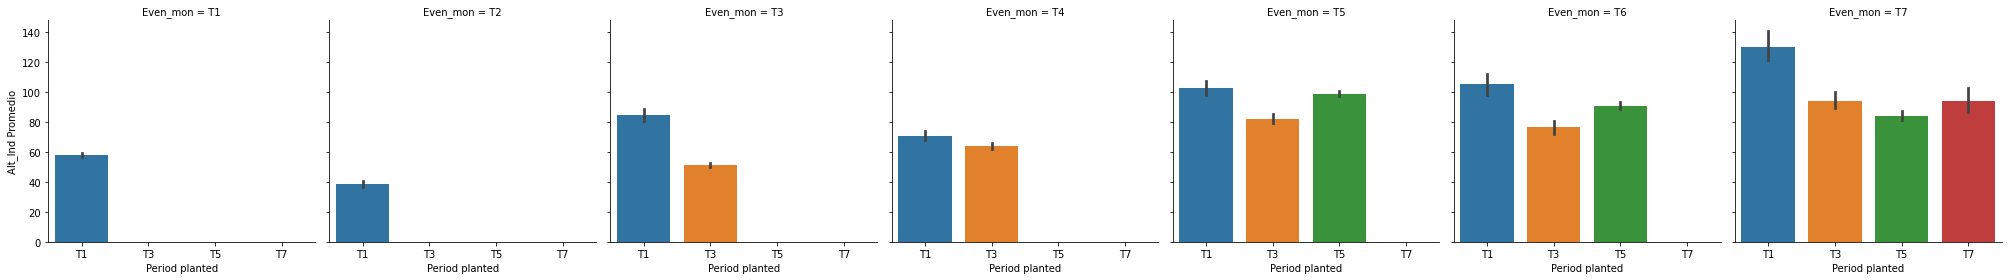

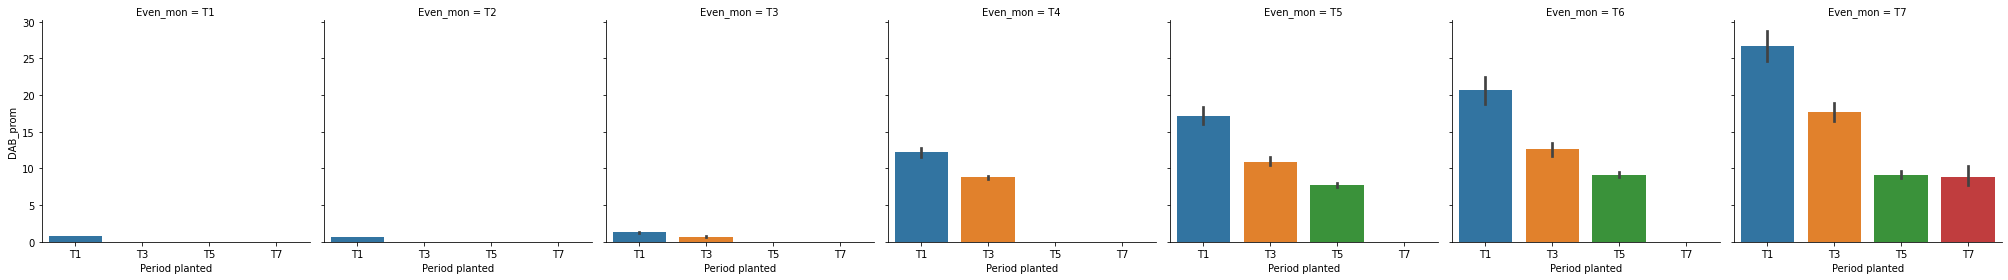

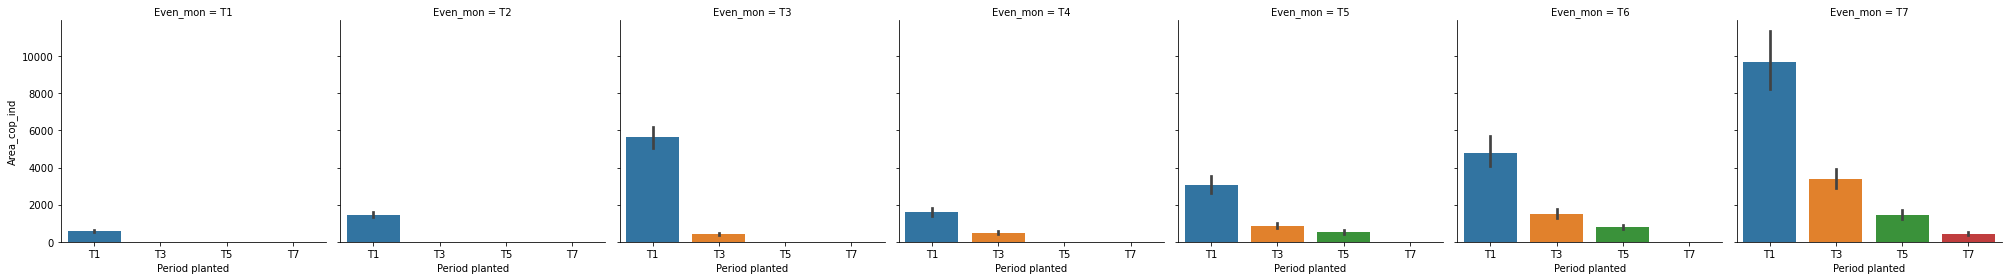

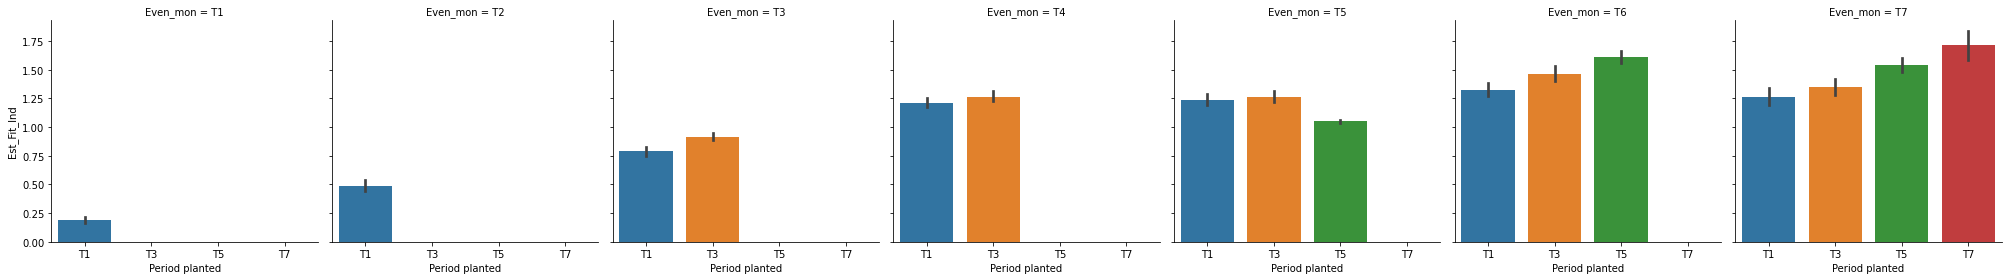

In [64]:
'''
The dataset actually has a lot of related data. all the columns with 'promedio' or 'prom'
are averages of the columns they refer to. 'Area_cop_ind' is the product of the 'Diam' columns
I previously modeled correlations for all the columns, and while a bit noisy, the correlations
support simplifying the dataset into 4 main numerical columns:
Alt_Ind Promedio: The averaged height from the 3 height columns
DAB_prom: The averaged basal stem diameter
Area_cop_ind: The area of the two Diam columns, obtained with the folliwing formula:
Area = Diam A * Diam B / 2
Est_Fit_Ind: The presence of negative visual health indicators from 0-4. Lower is better.
'''

variables = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']
for var in variables:
    g = sns.FacetGrid(reserve, col='Even_mon', hue='Period planted', height=4)
    g.map(sns.barplot, "Period planted", var, order=['T1', 'T3', 'T5', 'T7'])
    
# This shows that for the most part, the plants have grown over time.
# Between T5 and T6, there was a reduction in height in the younger T3 and T5 plants
# and an increase in negative plant health effects across the board.
# T5 plants were planted tall and skinny, which may have negative effects.

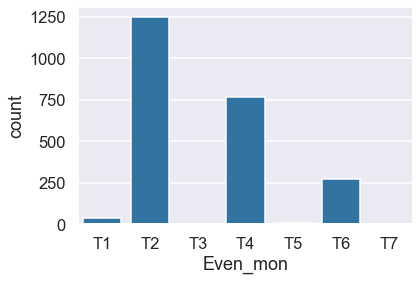

In [375]:
dead = reserve.loc[reserve['Sup_Ind'] == False]
events = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
sns.countplot(x='Even_mon', data=dead, order=events, color='tab:blue');
# This shows an increase in plant survival over time.

In [38]:
# The seemingly linear trend of dead  plants makes me wonder if there's a pattern. 
# Are we simply getting fewer deaths because mortality is highest among young plants, 
# and so the dead is actually mostly selected from the replacements?
# Or is the number of dead being selected in large enough amounts from older plants as well?

Total_plants = 2751
T2_dead = 1248
T4_dead = 764
T6_dead = 270
dead_ratio1 = T2_dead/Total_plants
dead_ratio2 = T4_dead/T2_dead
dead_ratio3 = T6_dead/T4_dead

print(dead_ratio1, ' : ', dead_ratio2, ' : ', dead_ratio3)

# If mortality was mostly determined by the amount of young plants, we would expect to see very similar ratios
# Instead it seems like there are other determining factors, and our second re-plant was the least successful.

0.4536532170119956  :  0.6121794871794872  :  0.35340314136125656


In [372]:
# Finally, which plants are dying the most? Is it older or younger plants?
groups = ['Even_mon', 'Period planted', 'Sup_Ind']
survival_distributions = reserve.groupby(groups)['ID'].count().reset_index()
survival_distributions

,Even_mon,Period planted,Sup_Ind,ID
0,T1,T1,False,37
1,T1,T1,True,2714
2,T2,T1,False,1248
3,T2,T1,True,1503
4,T3,T1,True,1363
5,T3,T3,True,1388
6,T4,T1,False,467
7,T4,T1,True,896
8,T4,T3,False,297
9,T4,T3,True,1091


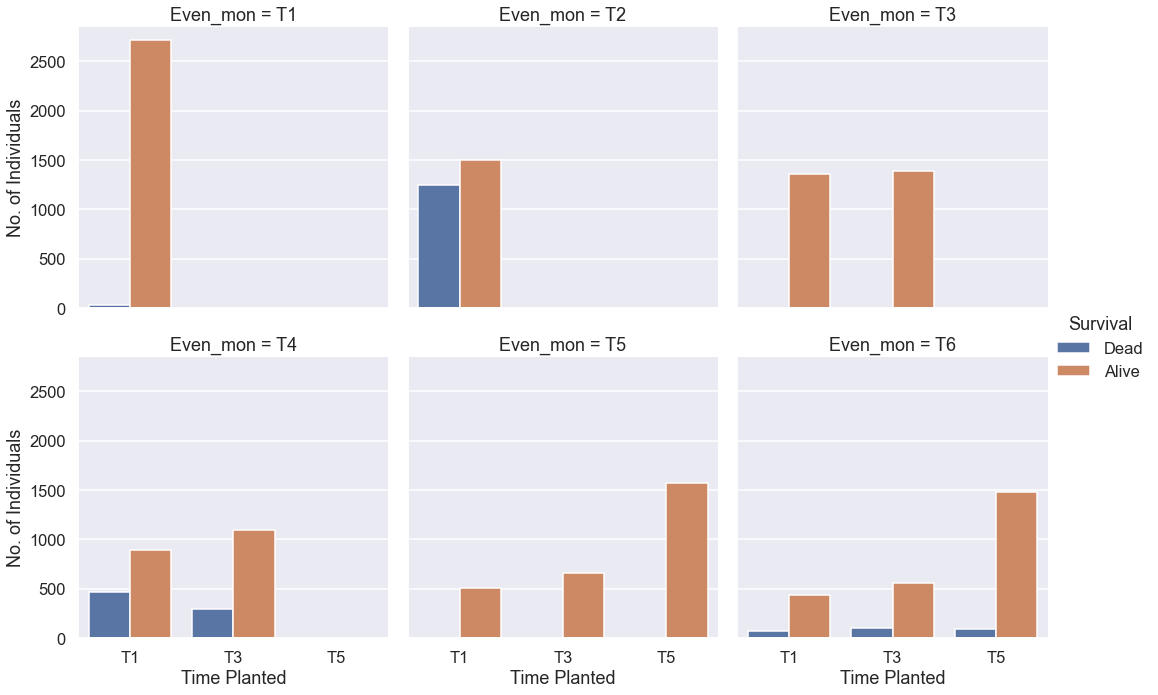

In [374]:
fig = sns.catplot(x='Period planted',
                  y="ID", 
                  hue="Sup_Ind", 
                  col='Even_mon', 
                  col_wrap=3, 
                  data=survival_distributions, 
                  kind='bar')
fig.set_axis_labels('Time Planted', 'No. of Individuals')
fig._legend.set_title('Survival')
for t, l, in zip(fig._legend.texts, ['Dead','Alive']):
    t.set_text(l)
# This chart would imply that other than the first mortality event in T2, mortality is being kept relatively low.
# However, the amount of plants that were added in T5 does not account for the amount of dead in T4
# We shall have to see how it continues in T7.

In [42]:
# This is how I got the values for the next plot
for value in reserve['Even_mon'].unique():
    print(reserve[reserve['Even_mon'] == value]['Period planted'].value_counts())

T1    2751
Name: Period planted, dtype: Int64
T1    2751
Name: Period planted, dtype: Int64
T3    1388
T1    1363
Name: Period planted, dtype: Int64
T3    1388
T1    1363
Name: Period planted, dtype: Int64
T5    1576
T3     664
T1     511
Name: Period planted, dtype: Int64
T5    1576
T3     664
T1     511
Name: Period planted, dtype: Int64


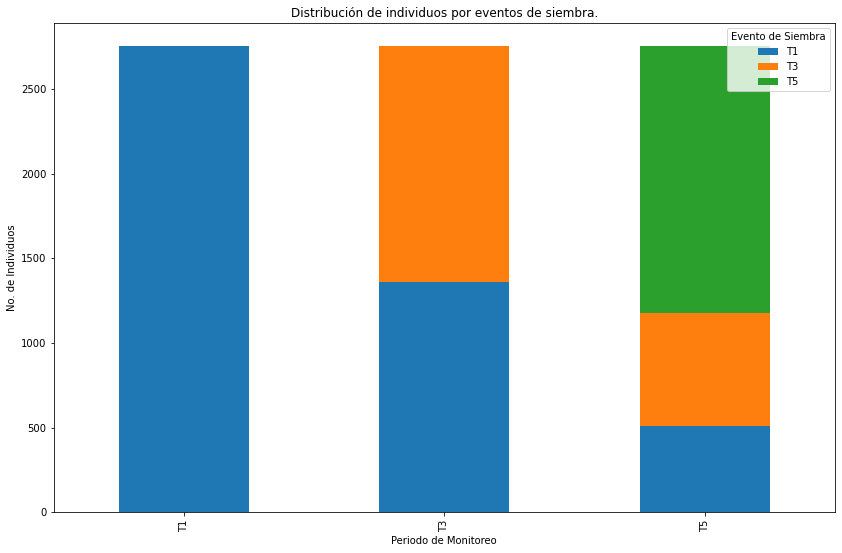

In [43]:
# This shows a very high mortality overall.
index = ['T1', 'T3', 'T5']
T1 = [2751, 1363, 511]
T3 = [0, 1388, 664]
T5 = [0, 0, 1576]


test = pd.DataFrame({'T1': T1, 'T3':T3, 'T5':T5}, index=index)
ax = test.plot.bar(stacked=True, figsize=(14,9))
ax.set_title('Distribución de individuos por eventos de siembra.')
ax.set_xlabel('Periodo de Monitoreo')
ax.set_ylabel('No. de Individuos')
ax.legend(title='Evento de Siembra');



In [44]:
'''To determine plant health we used two criteria:
1 - An affectation index from 0-4 covering the percentage of the plant displaying negative health traits
2 - A boolean indication of which types of afectation are visible on the plant. These are as follows:
    Coloracion - Coloration. Any off-coloring of a plant is noted here
    Vigor bajo - Low vigor. General malaise and especially lack of turgor in the leaf parts.
    Herbivoria - Herbivory. Consumption of leaf tissue by insects or animals.
    Patogenos - Pathogens. Evidence of disease caused by microorganisms
    Competencia - Competition. Crowding or strangulation by exotic species.
    Daño mecanico - Mechanical damage. Any breaks and tears not caused by the above.
    Anegamiento - Waterlogging. The presence of visible water in the area occupied by the plant root system.
    Daño por Curi - Rodent damage. This one was added later as a response to a specific issue we were facing.
    '''


'To determine plant health we used two criteria:\n1 - An affectation index from 0-4 covering the percentage of the plant displaying negative health traits\n2 - A boolean indication of which types of afectation are visible on the plant. These are as follows:\n    Coloracion - Coloration. Any off-coloring of a plant is noted here\n    Vigor bajo - Low vigor. General malaise and especially lack of turgor in the leaf parts.\n    Herbivoria - Herbivory. Consumption of leaf tissue by insects or animals.\n    Patogenos - Pathogens. Evidence of disease caused by microorganisms\n    Competencia - Competition. Crowding or strangulation by exotic species.\n    Daño mecanico - Mechanical damage. Any breaks and tears not caused by the above.\n    Anegamiento - Waterlogging. The presence of visible water in the area occupied by the plant root system.\n    Daño por Curi - Rodent damage. This one was added later as a response to a specific issue we were facing.\n    '

In [45]:
affectations_per_period = reserve.groupby(['Even_mon', 'Period planted'])[affectations].count().reset_index()
affectations_per_period

,Even_mon,Period planted,Coloracion,Vigor bajo,Herbivoria,Patogenos,Competencia,Daño mecanico,Anegamiento,Daño por Curi
0,T1,T1,64,56,16,115,2,6,0,0
1,T2,T1,7,139,194,2,0,9,8,0
2,T3,T1,615,166,405,1,1,32,30,0
3,T3,T3,863,198,433,1,1,28,25,0
4,T4,T1,815,103,443,5,896,2,0,0
5,T4,T3,1053,95,511,4,1091,2,0,0
6,T5,T1,500,82,344,475,1,5,0,0
7,T5,T3,659,106,392,630,1,6,0,0
8,T5,T5,1553,50,529,1515,0,22,0,0
9,T6,T1,407,20,335,77,116,5,1,65


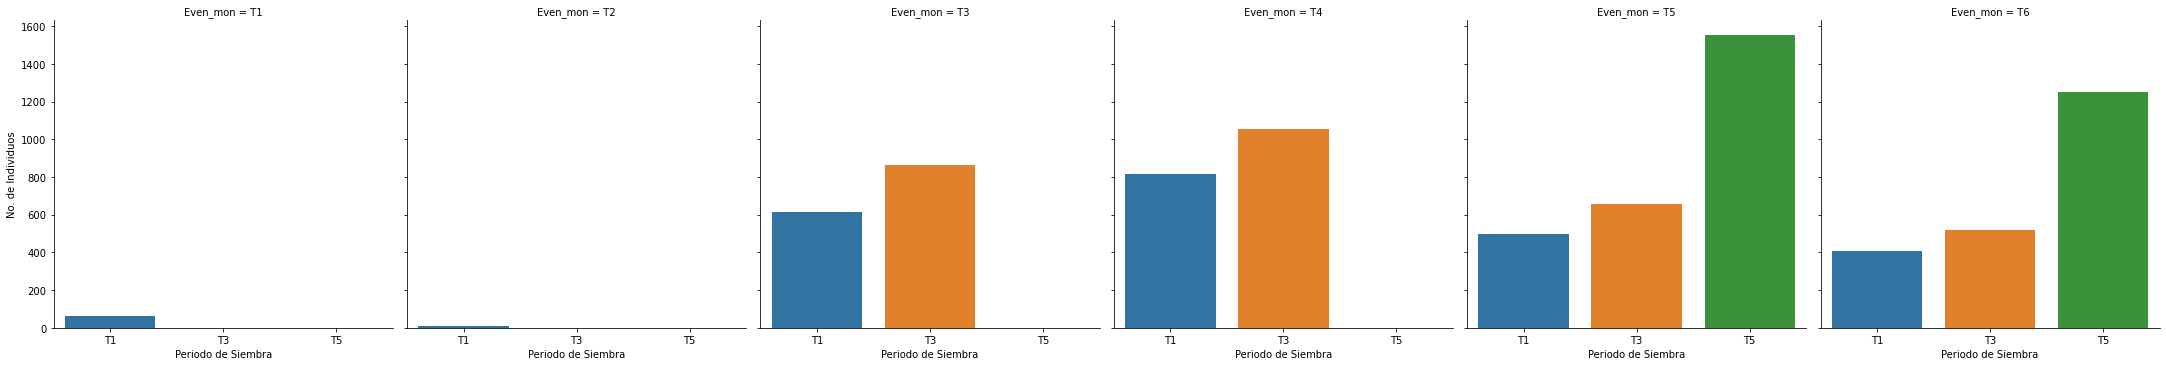

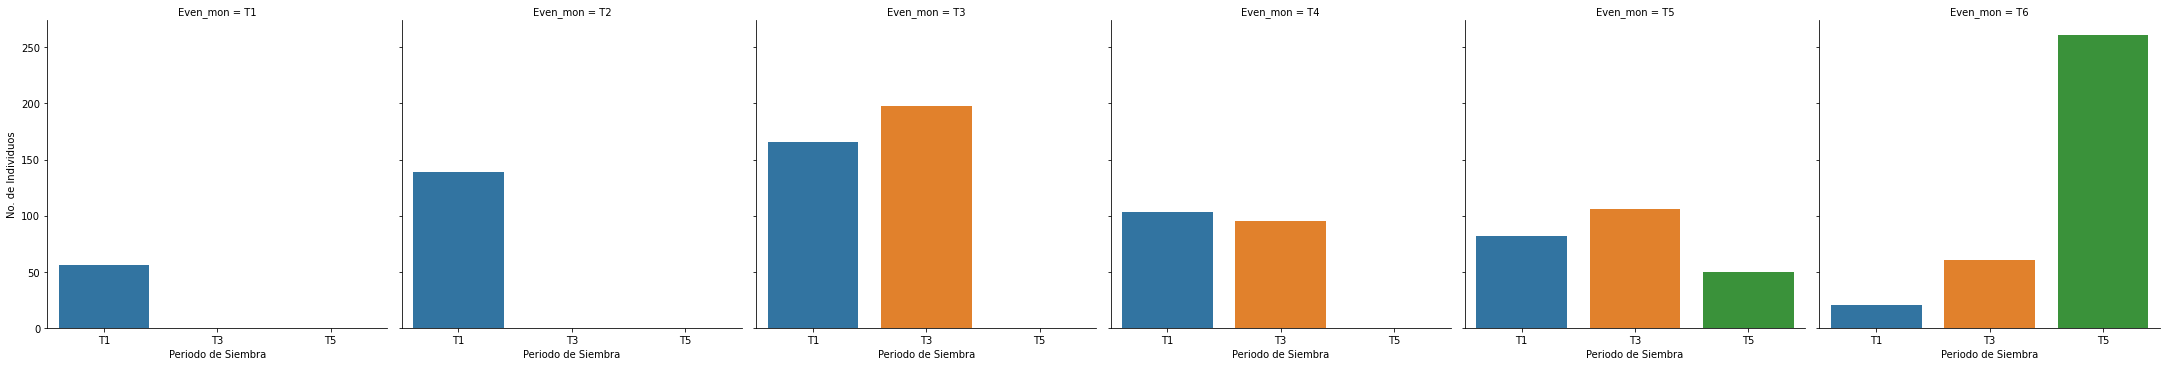

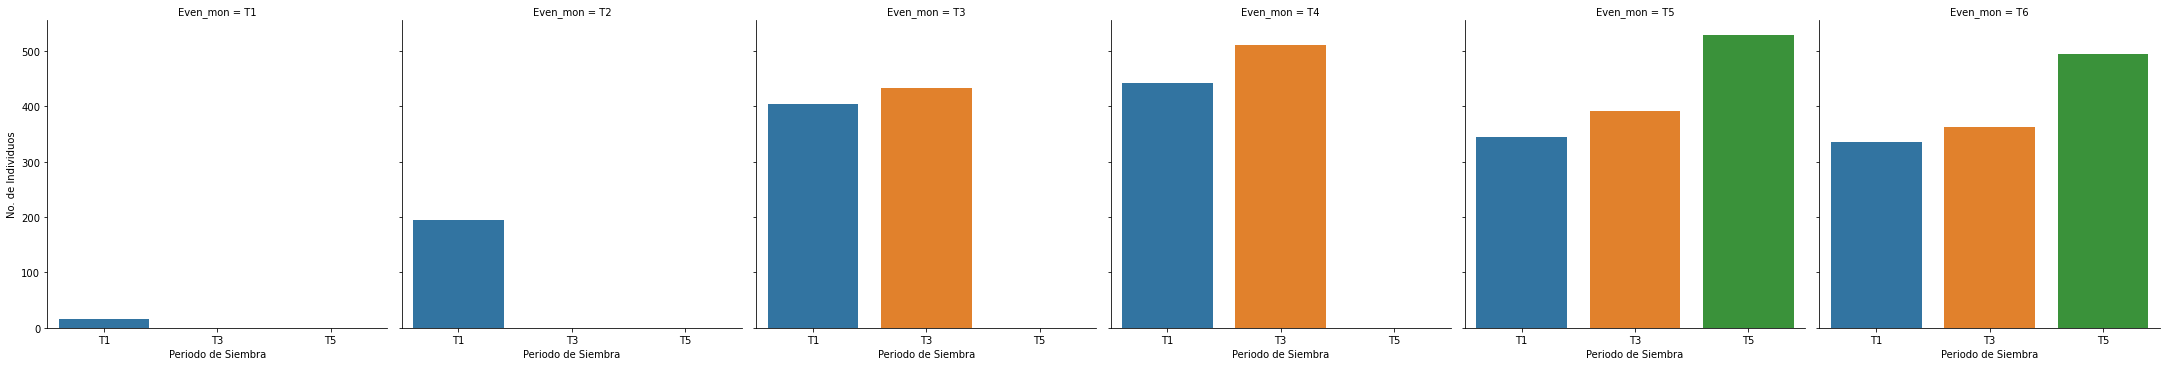

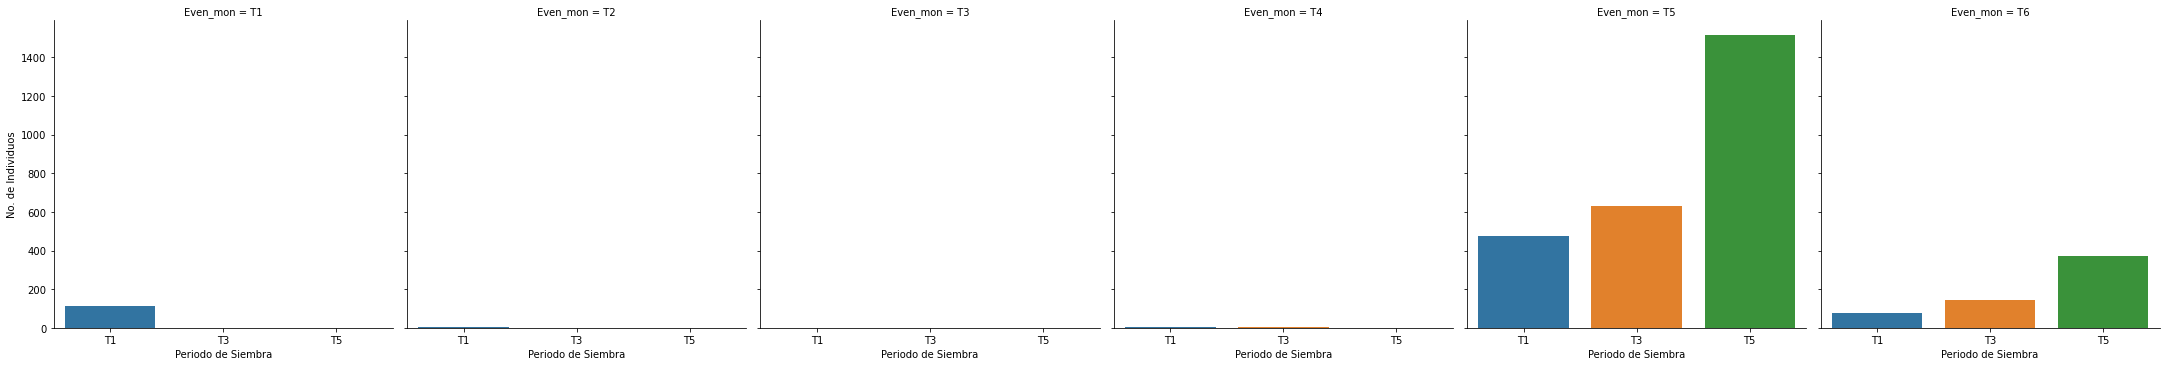

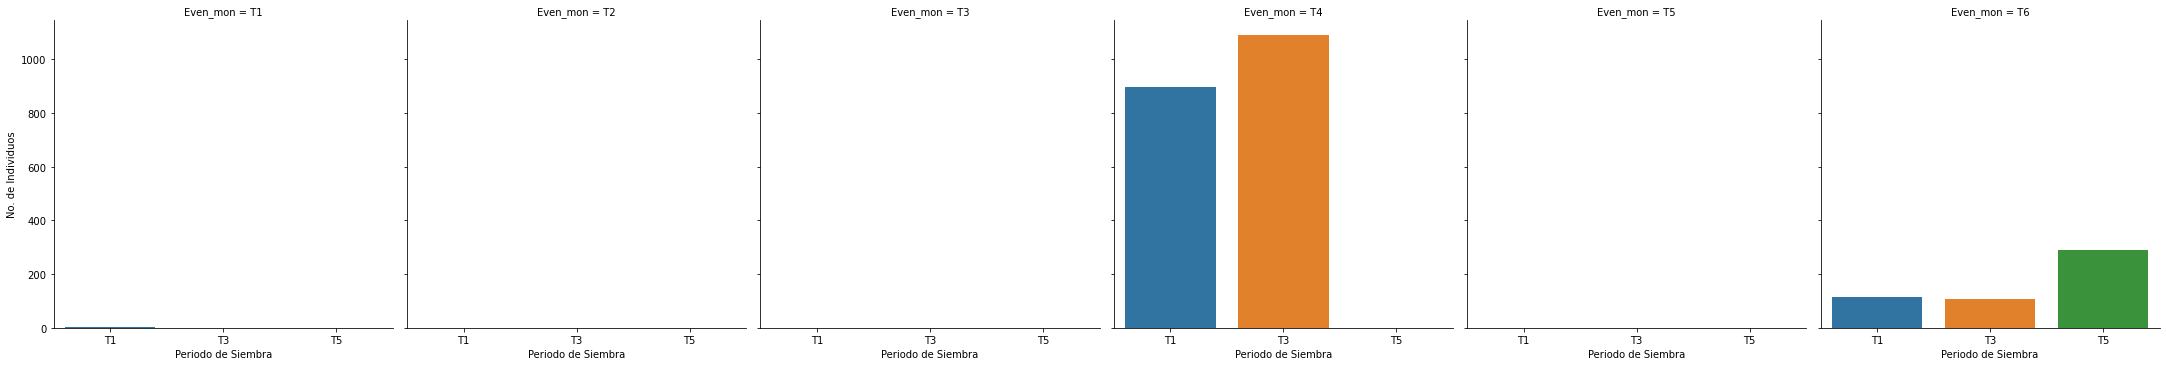

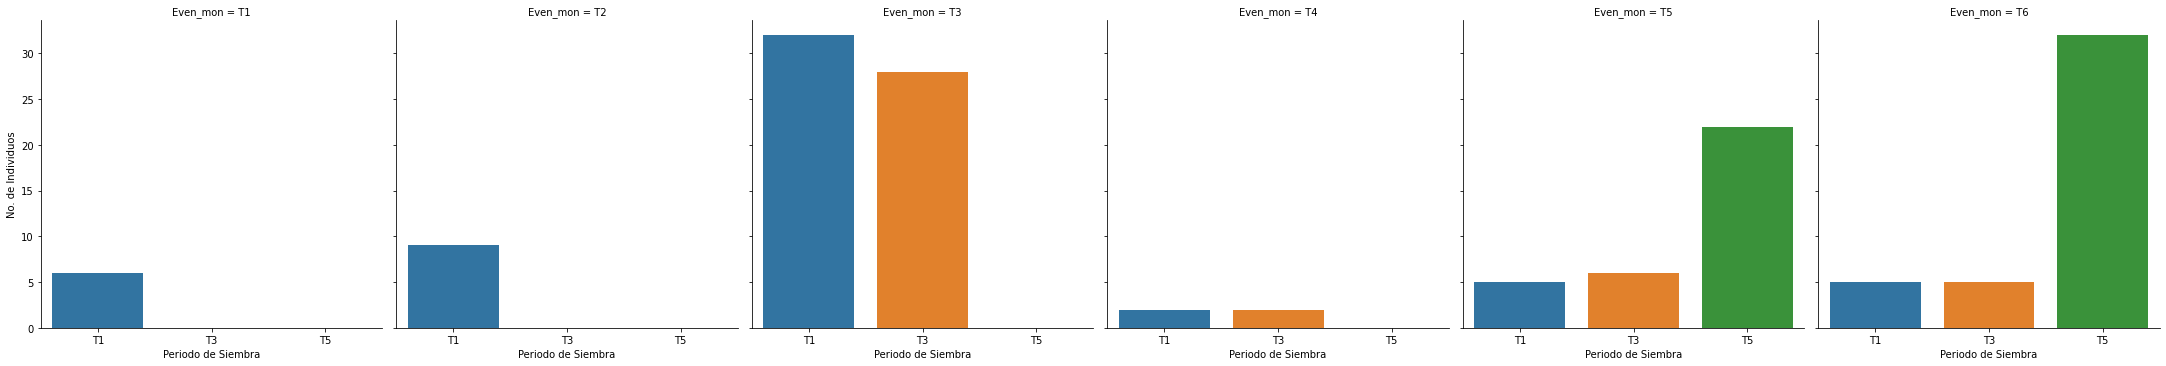

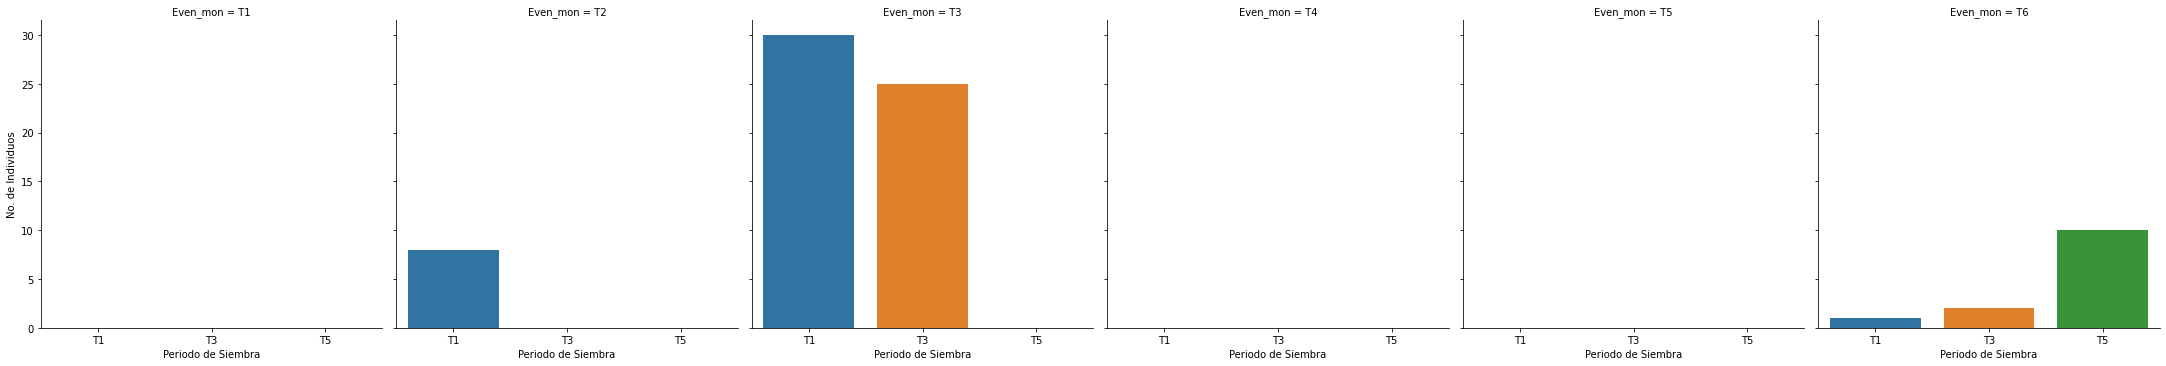

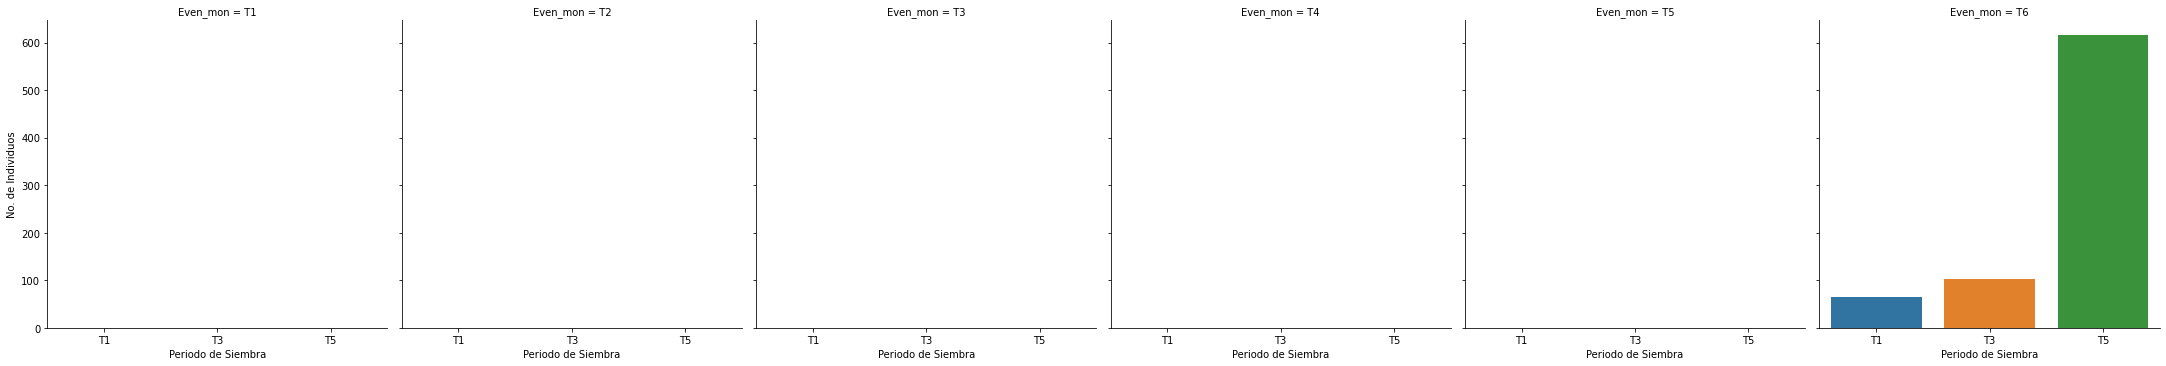

In [46]:
# Here we plot the types of affectations over time.
affectations_per_period = reserve.groupby(['Even_mon', 'Period planted'])[affectations].count().reset_index()
affectations_per_period

for aff in affectations:
    fig = sns.catplot(x="Period planted", 
                      y=aff, 
                      hue="Period planted", 
                      col='Even_mon', 
                      data=affectations_per_period, 
                      kind='bar', 
                      dodge=False)
    fig.set_axis_labels('Periodo de Siembra', 'No. de Individuos')

        
# It's unknown if the T1 plants were healthier at the beginning or if we simply changed our sample methods
# Starting from T2 it appears that internal plant factors like Coloration stay steady or decrease slightly over time
# Younger plants seem to suffer more from Low Vigor which will then decrease over time
# Herbivory seems to be fairly constant, which would make sense if the animals in question maintained steady populations
# Pathogens seem to have been measured mostly in T5 and affected younger plants disproportionately. Is this sampling error?
# Competition from exotic species seems to have been poorly tracked overall. The spike in T4 was due to a lack of cutting the grass
# Mechanical damage also seems inconsistently tracked. It does however seem to affect younger plants more.
# Waterlogging seems to be a periodic issue and not one that affects plants in a particularly strong fashion
# Previously the damage from Guinea Pigs was measured as Herbivory until T6, and is possibly counted twice in T6. They seem to favor the young plants.

'Coloracion', 'Vigor bajo', 'Herbivoria', 'Patogenos', 'Competencia', 'Daño mecanico', 'Anegamiento', 'Daño por Curi'

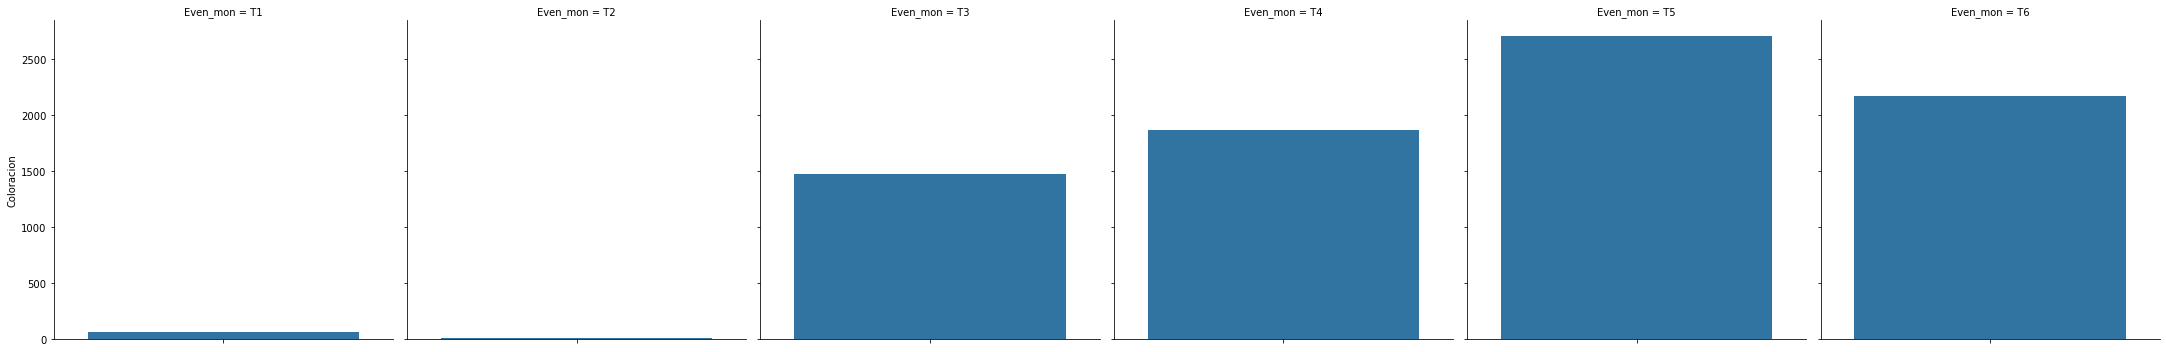

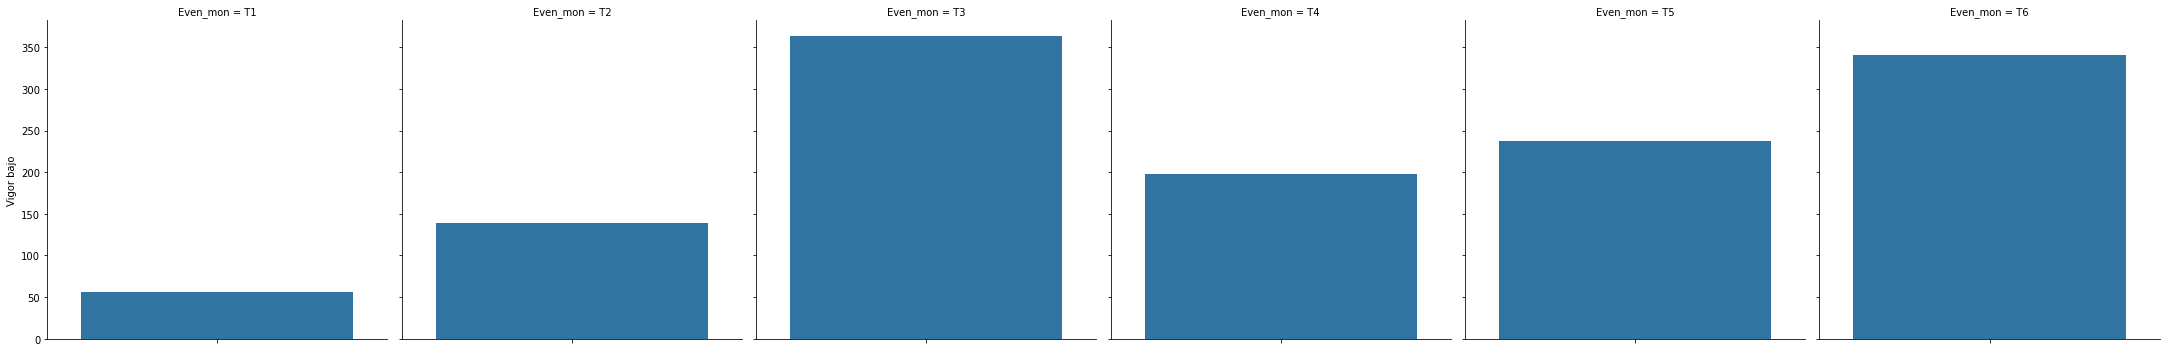

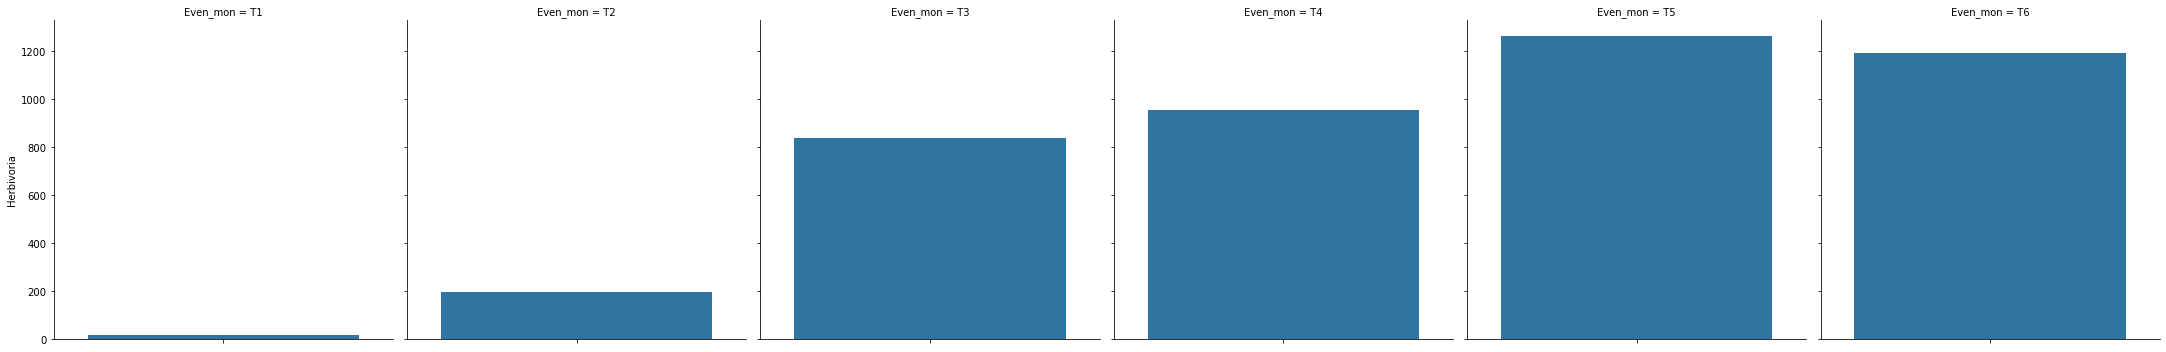

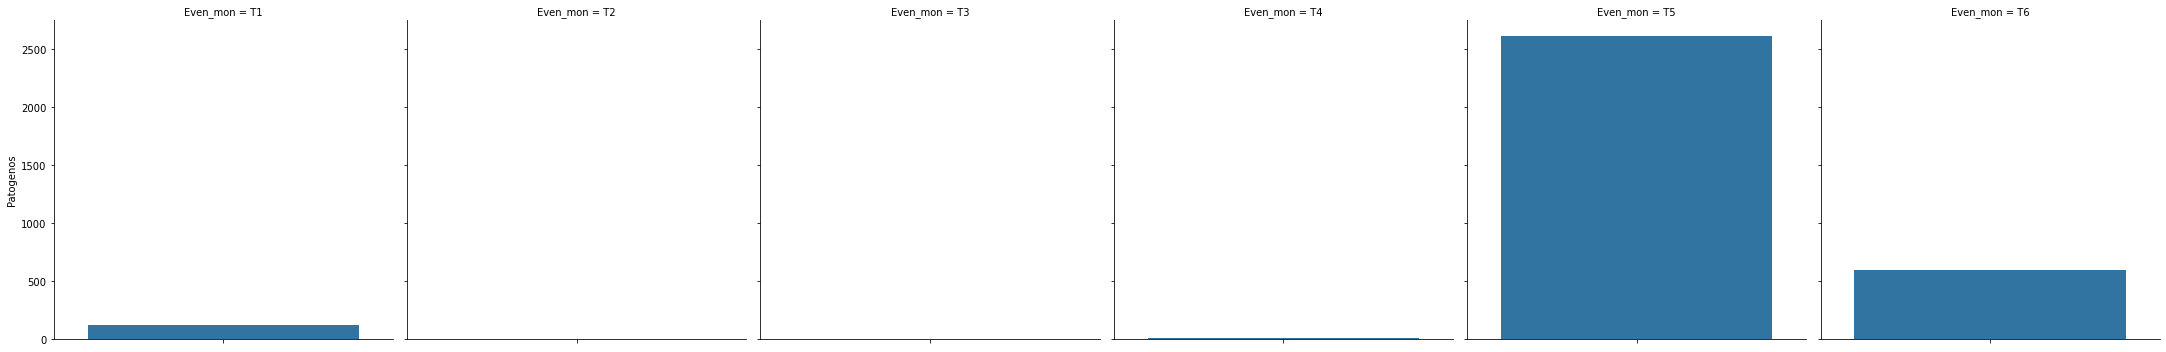

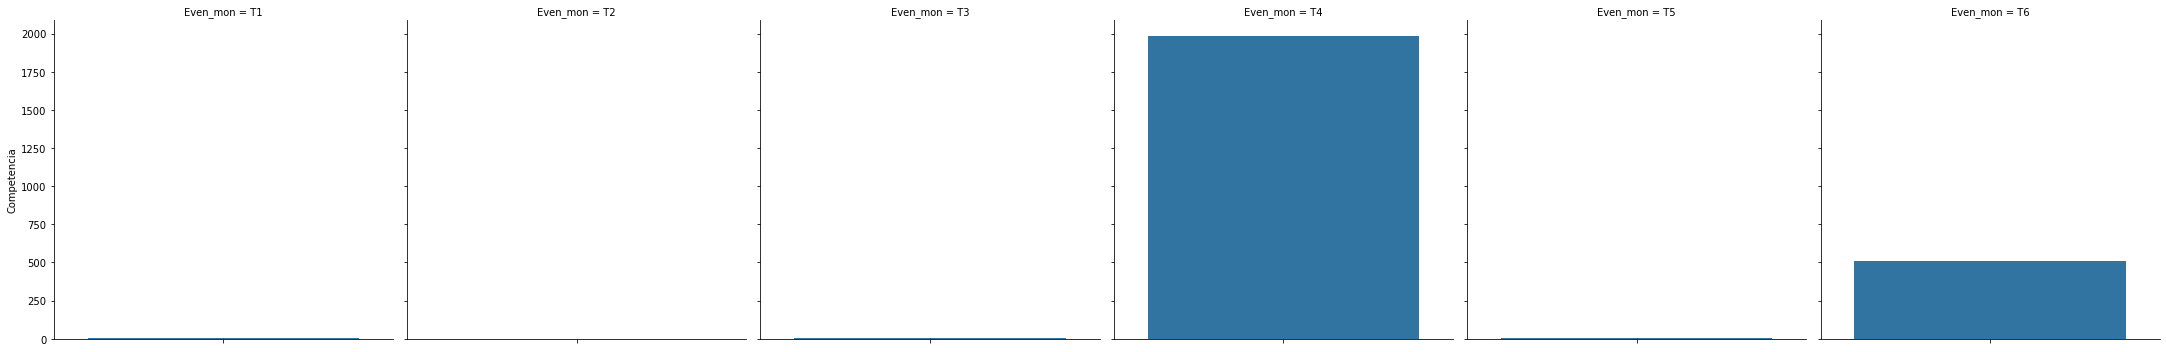

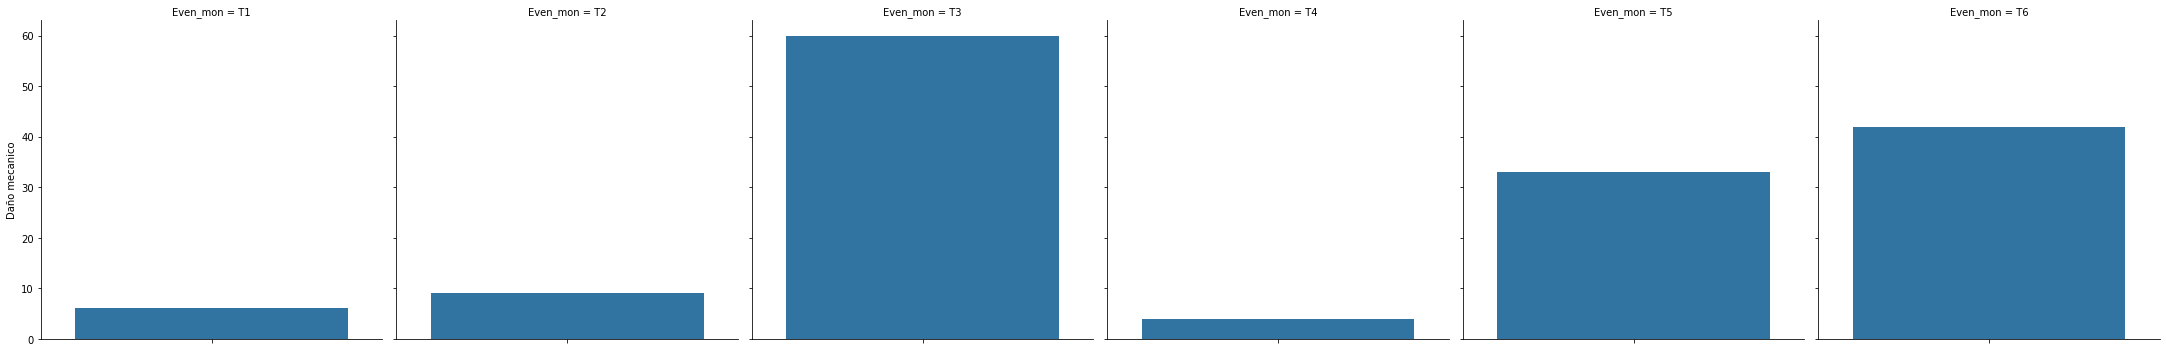

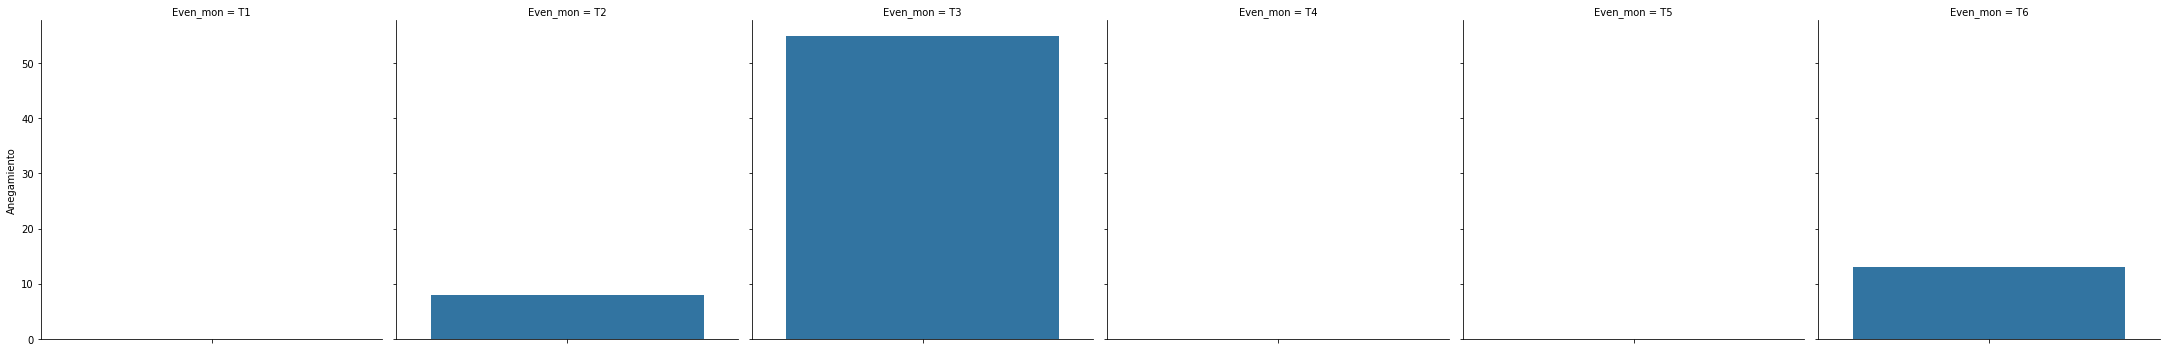

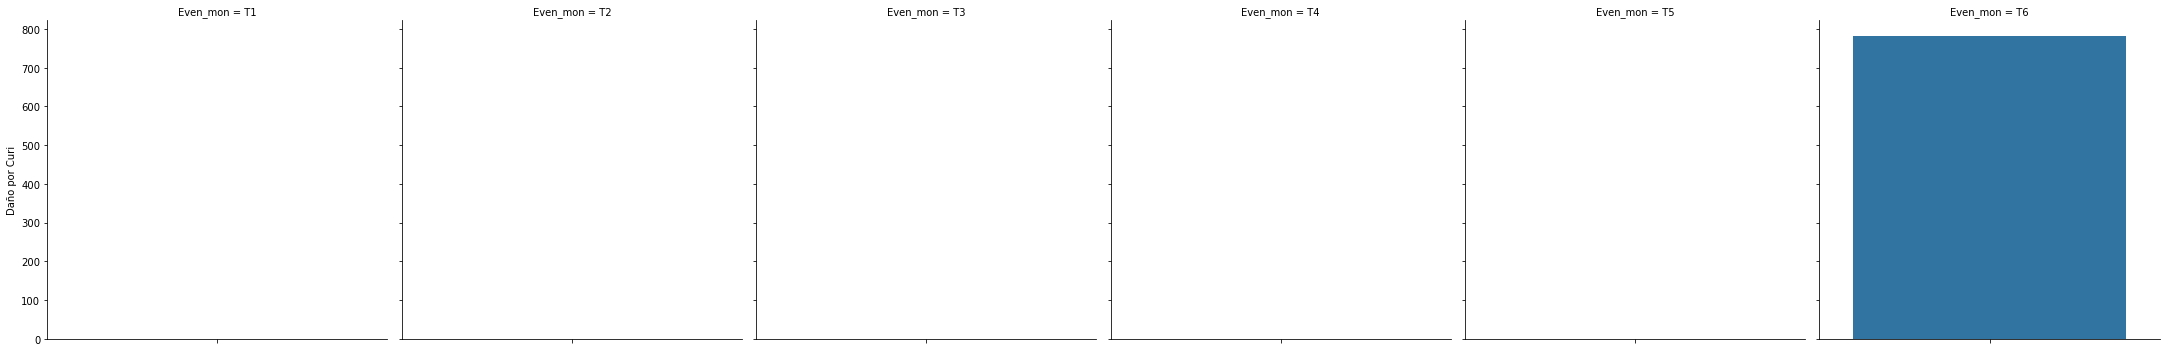

In [47]:
# Let's do it again without hue differentiation to see how overall populations were affected
affectations_per_period = reserve.groupby(['Even_mon'])[affectations].count().reset_index()
for aff in affectations:
    fig = sns.catplot(y=aff, 
                      col='Even_mon', 
                      data=affectations_per_period, 
                      kind='bar')
    fig.set_axis_labels(fontsize=20)
# If the youngest plants were the least healthy we would expect to see peaks in periods T1, T3, and T5, which seems to be true.
# The main exception is low vigor, which seems to be cyclical?

In [48]:

# It seems like overwhelmingly, the most recently planted individuals have the worst health.
# Apparently once a plant reaches a certain age or size, it stops being affected as heavily by health factors
# Whether this is a trend onthe ground or sampling bias would need to be properly verified.
# The implication is, however, that if we account for a certain percentage of young plant deaths, 
# the amount of plants that survive can be accounted for.

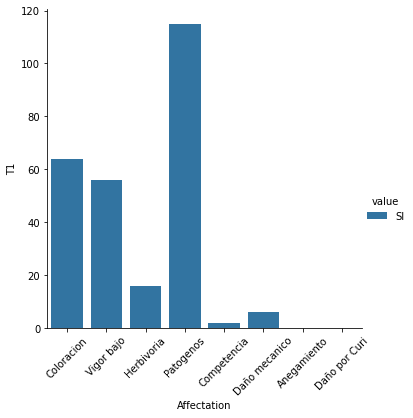

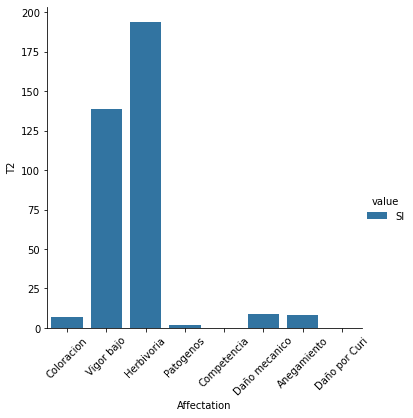

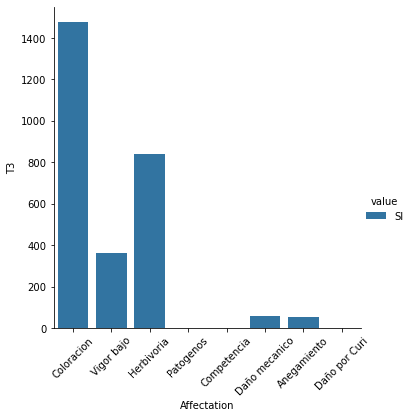

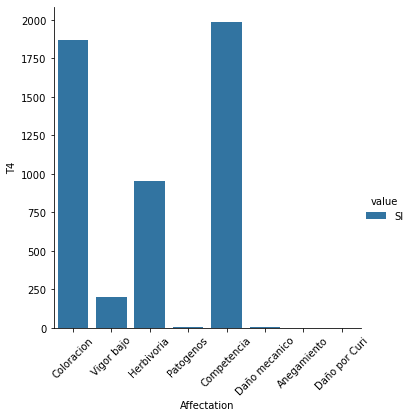

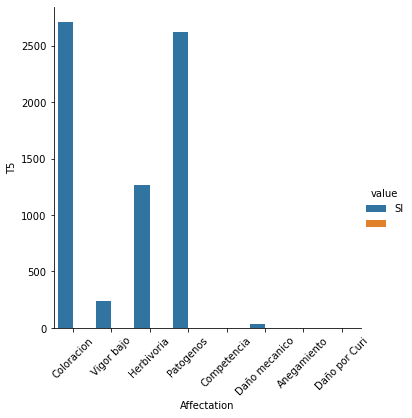

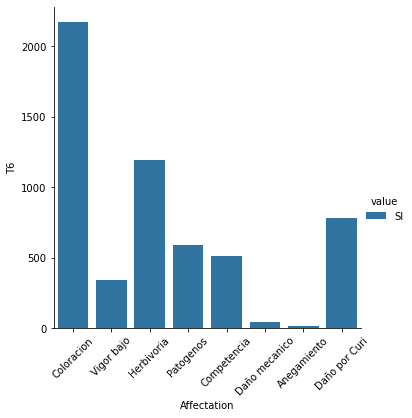

In [49]:
#['Even_mon', 'Est_Fit_Ind', 'Coloracion', 'Vigor bajo', 'Herbivoria', 'Patogenos', 'Competencia', 'Daño mecanico', 'Anegamiento', 'Daño por Curi']
for value in reserve['Even_mon'].unique():
    df_affs = reserve[reserve['Even_mon'] == value][affectations]
    #sns.countplot(x = 'variable', hue = 'value', data=pd.melt(df_affs))
    g = sns.catplot(x='variable', 
                    hue='value', 
                    data=pd.melt(df_affs), 
                    kind='count')
    g.set(xlabel='Affectation', ylabel=value)
    plt.xticks(rotation=45)


In [369]:
# Now we see which of the quantitative variables are the most important. I modelled all of them and then narrowed it down.
# The 4 remaining variables are averages or composites of all the other quantitative variables and as such are the best fit.

# Grab all the numerical data from the dataset, also split into sample periods
quants = ['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']
num_reserve = reserve[quants]
r_num_dict = {}
for value in reserve['Even_mon'].unique():
    r_num_dict[value] = reserve[reserve['Even_mon'] == value]
    r_num_dict[value] = r_num_dict[value][quants]

Text(0.5, 1.0, 'Predictive Power of Quantitative Variables')

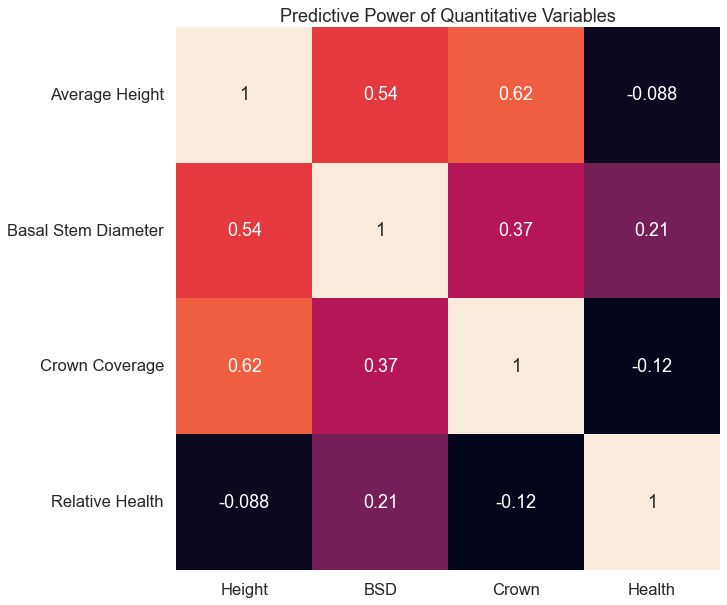

In [365]:

plt.figure(figsize = (20,10))
ylabels = ['Average Height', 'Basal Stem Diameter', 'Crown Coverage', 'Relative Health']
xlabels = ['Height', 'BSD', 'Crown', 'Health']
ax = sns.heatmap(num_reserve.corr(), 
                 annot=True, 
                 square=True, 
                 cbar=False, 
                 xticklabels=xlabels, 
                 yticklabels=ylabels)
sns.set_context('talk')
ax.set_title('Predictive Power of Quantitative Variables')

#plt.savefig(figures+'Correlaciones', dpi=1200)
# Height is most correlated with crown area, then stem diameter. 
# Amazingly plant health may have a weak correlation with stem thickness.

In [80]:
len(r_num_dict)

6

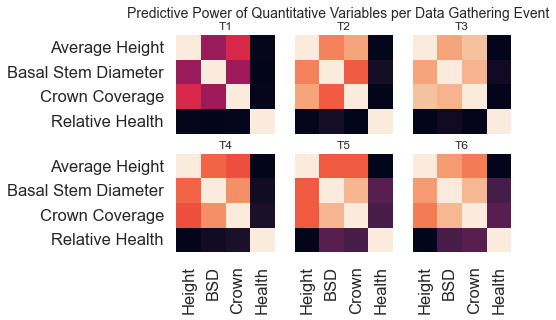

<Figure size 1080x1080 with 0 Axes>

In [370]:
fig, axs = plt.subplots(2,3)
plt.figure(figsize = (15, 15))
row = 0
col = 0
rep = 0
fig.suptitle('Predictive Power of Quantitative Variables per Data Gathering Event', fontsize=14)
#sns.set(font_scale = .9)
for item in r_num_dict:
    if row == 1:
        x_labels = xlabels
    else:
        x_labels = []
    if col == 0:
        y_labels = ylabels
    else:
        y_labels = []
    sns.heatmap(r_num_dict[item].corr(), 
                ax=axs[row, col], 
                annot=False, 
                square=True, 
                cbar=False, 
                xticklabels=x_labels, 
                yticklabels=y_labels)
    axs[row, col].set_title(item, fontsize=12)
    if rep == 2:
        col = 0
        row = 1
    else:
        col += 1
    rep += 1
  

#fig.savefig(figures+'Correlaciones_por_monitoreo', dpi=1200, bbox_inches='tight')
# T1 has the weakest correlation. If we excluded T1 from the aggregate Principal Component Analysis we would actually get
# much stronger correlations.
# This breakdown on the other hand weakens the plant health/stem thickness correlation.

In [53]:
# Finally, is there a geographic component to the success of the plants?
# Overall growth of plants
# Growth of plants over time
# Growth of plants per species
# Incidence of affectations
# Incidence of affectations over time

In [157]:
reserve['Sup_Ind']

0        False
1        False
2        False
3        False
4        False
         ...  
16501    False
16502    False
16503    False
16504    False
16505    False
Name: Sup_Ind, Length: 16506, dtype: bool

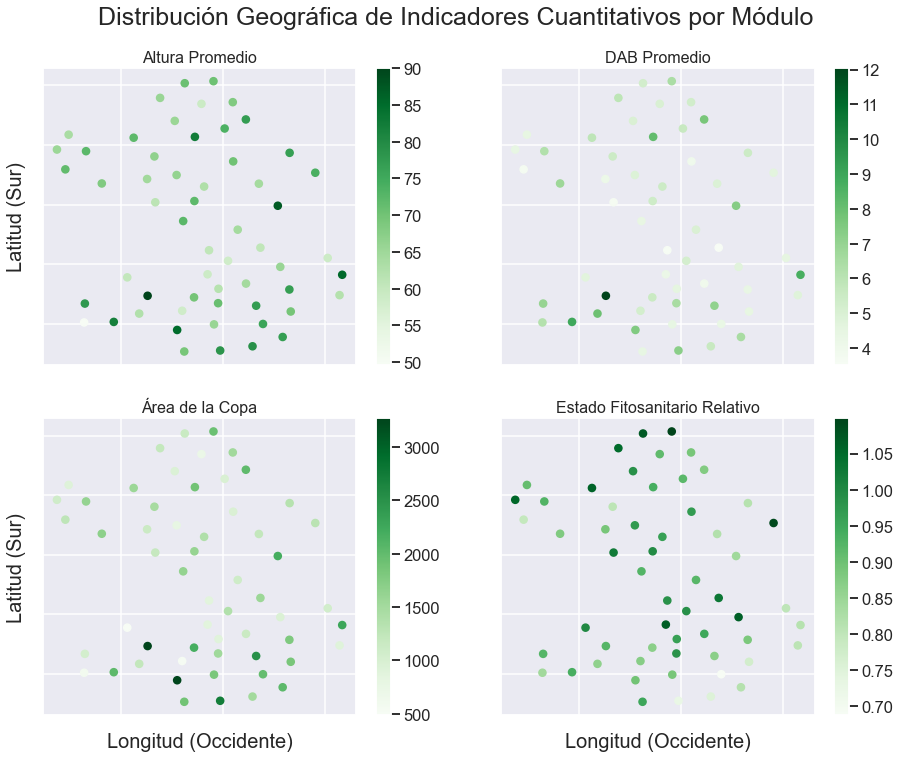

In [347]:
# Overall quantitative values
geo_quant = reserve.groupby(['COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']].mean().reset_index()


valores = {'Alt_Ind Promedio': 'Average Plant Height', 
           'DAB_prom': 'Stem Basal Diameter', 
           'Area_cop_ind': 'Crown Coverage',
           'Est_Fit_Ind': 'Relative Health'}
fig, ax = plt.subplots(2, 2, figsize=(13,10))
fig.tight_layout()
row = 0
col = 0
rep = 0
for valor in valores:
    
    
    geo_quant.plot.scatter(x='COOR_ESTE', 
                           y='COOR_NORTE', 
                           xlabel=True, 
                           c=geo_quant[valor].array, 
                           colormap='Greens',
                           colorbar=True,
                           ax=ax[row,col],
                           s=50
                          )
    ax[row,col].set_yticklabels([])
    ax[row,col].set_xticklabels([])
    if row == 1:
        ax[row,col].set_xlabel('Longitude (West)', fontsize=20)
    else:
        ax[row,col].set_xlabel('')
    if col == 0:
        ax[row,col].set_ylabel('Latitude (South)', fontsize=20)
    else:
        ax[row,col].set_ylabel('')
    ax[row,col].set_title(valores[valor], fontsize=16)
    if rep == 1:
        col = 0
        row = 1
    else:
        col += 1
    rep += 1

plt.suptitle('Geographic Distribution of Biomass Metrics per Module', fontsize=25, y=1.05)
    
#fig.savefig(figures+'Distribucion de Indicadores', dpi=1200, bbox_inches='tight')

In [235]:
species = reserve['Especie'].unique()
species_list = []
for item in species:
    species_list.append(item)
to_remove = ['Hesperomeles sp.', 'Weinmannia sp.', 
                    'Ageratina sp.', 'Bucquetia glutinosa',
                   'Tibouchina lepidota', 'Ceroxylon alpinum', 
             'Myrsine dependens', 'Vallea stipularis',
            'Myrsine guianensis']#The least populous species so figures of these would be useless.
for item in to_remove:
    species_list.remove(item)

In [236]:
len(species_list)

20

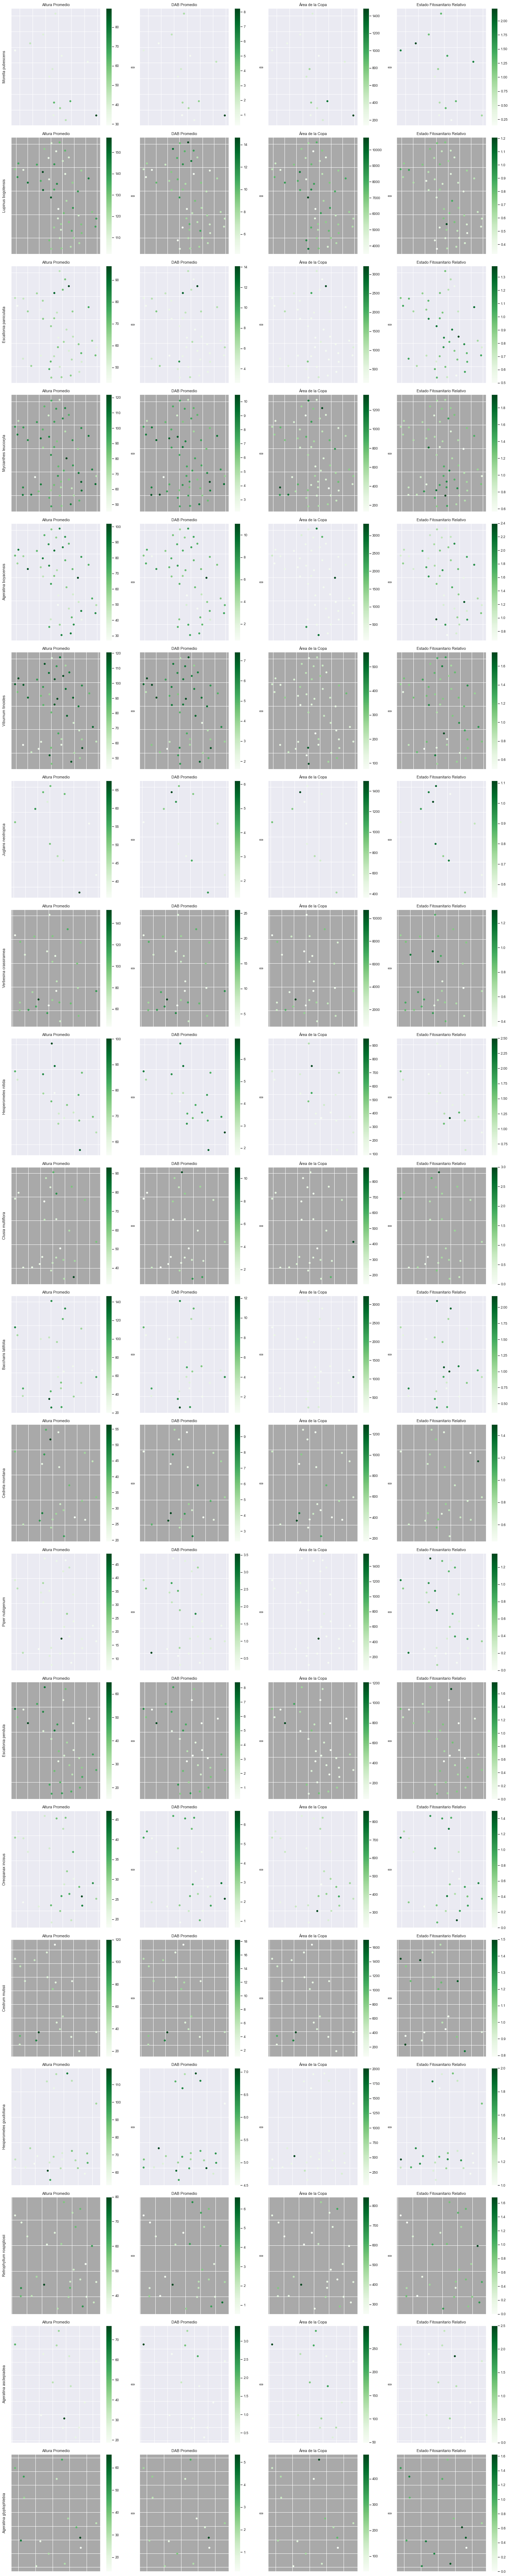

In [338]:
#Same as above but group by species.
geo_quant_spec = reserve.groupby(['Especie','COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind']].mean().reset_index()



fig, axs = plt.subplots(nrows = len(species_list), ncols=4, figsize=(20, 100))
row = 0
for especie in species_list:
    
    col = 0
    for valor in valores:
        geo_quant_spec[geo_quant_spec['Especie'] == especie].plot(kind='scatter', 
                                                                  x='COOR_ESTE', 
                                                                  y='COOR_NORTE', 
                                                                  ax=axs[row, col], 
                                                                  xlabel=True, 
                                                                  c=geo_quant_spec[geo_quant_spec['Especie'] == especie][valor].array, 
                                                                  colorbar=True, 
                                                                  cmap='Greens',
                                                                  title=(valores[valor]))
        axs[row, col].set_xticklabels([])
        axs[row, col].set_yticklabels([])
        axs[row, col].set_xlabel('')
        if row%2 == 1:
            axs[row, col].patch.set_facecolor('darkgray')
        if col == 0:
            axs[row, col].set_ylabel(especie)
        else:
            axs[row, col].set_ylabel([])
        
        col += 1
    row += 1
fig.tight_layout()

In [58]:
geo_quant = reserve.groupby(['Especie','COOR_ESTE', 'COOR_NORTE'])[['Alt_Ind Promedio', 'DAB_prom', 'Area_cop_ind', 'Est_Fit_Ind', 'Sup_Ind']].mean().reset_index()
geo_quant

,Especie,COOR_ESTE,COOR_NORTE,Alt_Ind Promedio,DAB_prom,Area_cop_ind,Est_Fit_Ind,Sup_Ind
0,Ageratina asclepiadea,-73.910815,4.792462,52.058333,3.422500,299.1625,0.848485,0.825000
1,Ageratina asclepiadea,-73.910439,4.792561,24.214286,0.242857,126.607143,0.0,0.500000
2,Ageratina asclepiadea,-73.910370,4.791235,18.583333,0.283333,90.25,0.5,0.500000
3,Ageratina asclepiadea,-73.910138,4.792568,38.688889,1.829630,204.907407,0.7,0.714286
4,Ageratina asclepiadea,-73.910106,4.792845,41.750000,1.400000,199.5,0.666667,0.750000
...,...,...,...,...,...,...,...,...
621,Viburnum tinoides,-73.909428,4.791240,62.500000,3.845098,143.539216,1.104167,0.923077
622,Weinmannia sp.,-73.910411,4.791085,43.357143,1.479762,472.607143,0.4,0.625000
623,Weinmannia sp.,-73.909992,4.792638,39.630208,2.678125,343.03125,0.769231,0.812500
624,Weinmannia sp.,-73.909950,4.792362,40.191358,2.089506,225.092593,0.703704,0.900000


In [289]:
affectations

['Sup_Ind',
 'Coloracion',
 'Vigor bajo',
 'Herbivoria',
 'Patogenos',
 'Competencia',
 'Daño mecanico',
 'Anegamiento',
 'Daño por Curi']

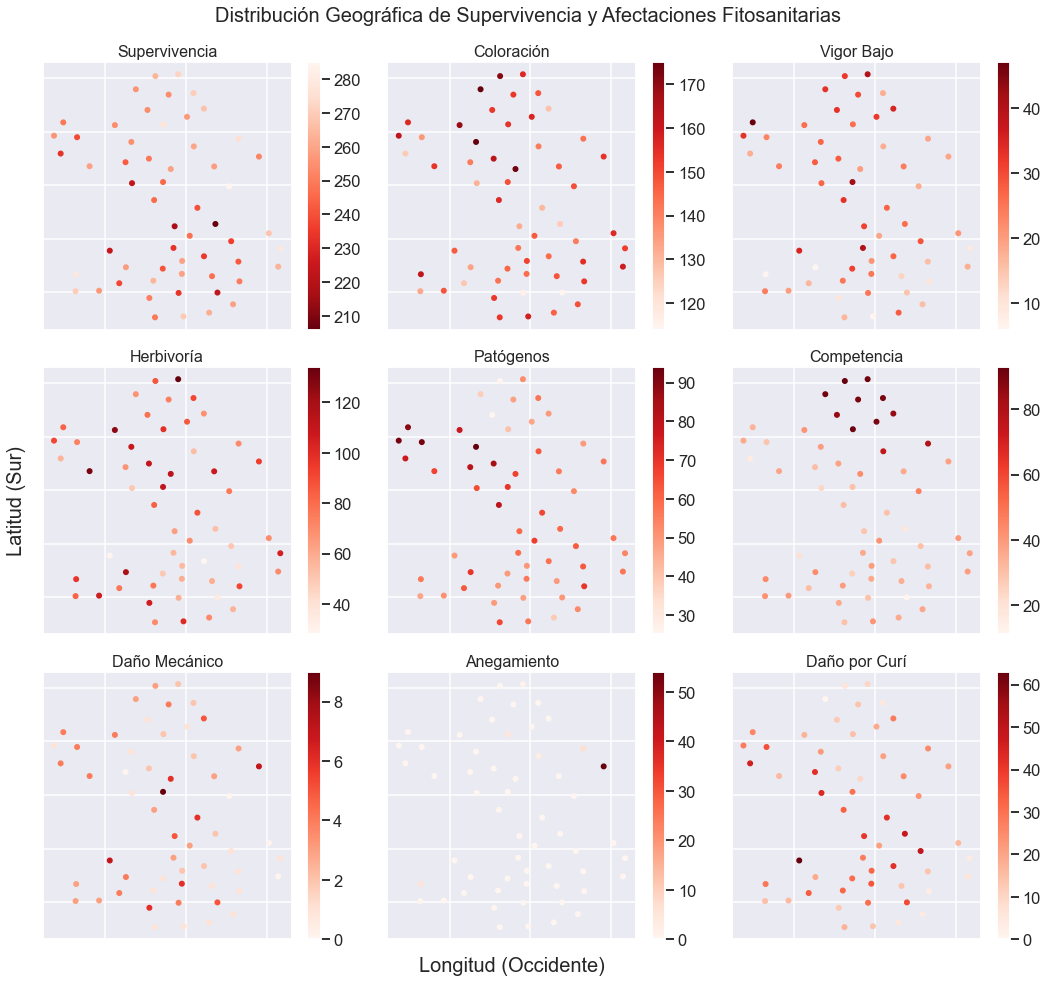

In [349]:
# Overall qualitative values
groups = ['No_Mod', 'COOR_ESTE', 'COOR_NORTE']
geo_qual = reserve.groupby(groups)[affectations].sum().reset_index()
#Multiply the values of Module 34 because it's 1/7th the size of the rest to normalize.
for aff in affectations:
    geo_qual.iloc[33, geo_qual.columns.get_loc(aff)] = geo_qual.iloc[33, geo_qual.columns.get_loc(aff)]*7
aff_dict = {'Sup_Ind' : 'Survival',
 'Coloracion': 'Coloration',
 'Vigor bajo': 'Low Vigor',
 'Herbivoria': 'Herbivory',
 'Patogenos': 'Pathogens',
 'Competencia': 'Competition',
 'Daño mecanico': 'Mechanical Damage',
 'Anegamiento': 'Flooding',
 'Daño por Curi': 'Guinea Pig'}

fig, ax = plt.subplots(3, 3, figsize=(15, 14))
fig.suptitle('Geographic Distribution of Survival and Health Values', fontsize=20)
row = 0
col = 0
rep = 0
for aff in aff_dict:
    if row == 0 and col == 0:
        cmap = 'Reds_r'
    else:
        cmap = 'Reds'
    geo_qual.plot(kind='scatter', 
                  x='COOR_ESTE', 
                  y='COOR_NORTE', 
                  c=geo_qual[aff].array, 
                  colorbar=True, 
                  cmap=cmap,
                  ax=ax[row, col])
    ax[row, col].set_title(aff_dict[aff], fontsize=16)
    ax[row, col].set_xticklabels([])
    ax[row, col].set_yticklabels([])
    if row == 2 and col == 1:
        ax[row, col].set_xlabel('Longitude (West)', fontsize=20)
    else:
        ax[row, col].set_xlabel('')
    if col == 0 and row == 1:
        ax[row, col].set_ylabel('Latitude (South)', fontsize=20)
    else:
        ax[row, col].set_ylabel('')
    if rep == 2 or rep == 5:
        row += 1
        col = 0
    else:
        col += 1
    rep += 1
fig.tight_layout()
#fig.savefig(figures+'Distribucion de Afectaciones', dpi=1200, bbox_inches='tight')

In [ ]:
#We need a graph for change in species composition over time.
#See if the stats for reproductive activity are useful?
#Bring over the Curi graphs
#Bring over the best and worst performing species graphs


In [384]:
species_composition = reserve.groupby(['Even_mon','Especie'], as_index=False)['ID'].count()
species_composition = species_composition[species_composition['Especie'].str.contains(' sp.') == False]


In [402]:
describes = pd.DataFrame()
for time in events:
    describes[time] = species_composition[species_composition['Even_mon'] == time].describe()
describes.drop('T7', axis=1, inplace=True)
describes.reset_index(inplace=True)

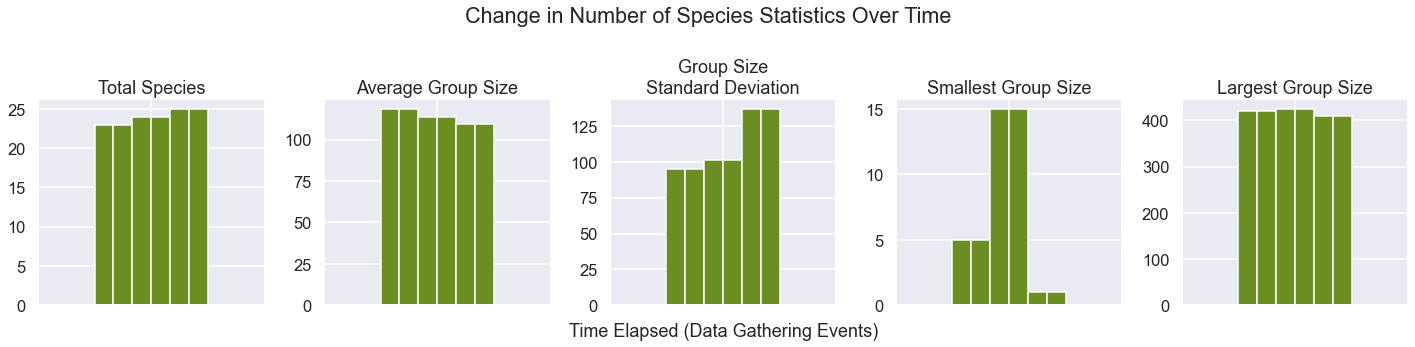

In [420]:
fig, ax = plt.subplots(1,5, figsize=(20,5))
vals = {'count': 'Total Species',
       'mean': 'Average Group Size',
       'std': 'Group Size\nStandard Deviation',
       'min': 'Smallest Group Size',
       'max': 'Largest Group Size'}
col = 0
for val in vals:
    describes[describes['index'] == val].plot.bar(ax=ax[col], color='olivedrab')
    ax[col].set_title(vals[val])
    ax[col].set_xticklabels([])

    legend = ax[col].legend()
    legend.remove()
    col += 1
ax[2].set_xlabel('Time Elapsed (Data Gathering Events)')
fig.suptitle('Change in Number of Species Statistics Over Time')
fig.tight_layout()
#This chart shows that diversity in planted species has increased, but variance has also increased.

In [432]:
reproductive1 = reserve[reserve['Observaciones_Crec'].str.contains('Boton')]
reproductive2 = reserve[reserve['Observaciones_Crec'].str.contains('Flor')]
reproductive3 = reserve[reserve['Observaciones_Crec'].str.contains('Fruto')]
reproductive = pd.concat([reproductive1, reproductive2, reproductive3], axis=0)
reproductive.groupby(['Even_mon']).count() 
#Reproductive activity is definitely present but not measured consistently.

In [ ]:
'''Part 5: Evaluation and Deployment
    Mechanically:
        Is the process working? 
        Are the plants growing properly? 
        Are they surviving? 
        Are they healthy? Why or why not?
On average, the indicators for plant growth (Height, Stem Diameter, Crown Area) are increasing
over time for all cohorts. Plant mortality is however, consistently high, ranging between 40-60%
of total plants. There appears to be a cutoff point after which plant mortality drops significantly.
While it can be assumed that plant health remains within acceptable parameters in surviving plants,
the factors which affect them appear to constantly be increasing over time. Whether this is a
measurement error or a trend which has yet to conclude will become clearer over time.
    
    Ecologically:
        Do we have a good representation of species? 
        Is there evidence of interactions or conflict with local species? 
        How are these interactions affecting our metrics?
Species diversity has dropped over time, with the plants that died being replaced by whatever
was available in the greenhouse. There is strong evidence that the plants are serving
as food and shelter for a local guinea pig population, which would hopefully result in an
increase in predator species as well. A cursory glance at the geographic plots also implies
a strong edge effect, meaning that in places where the introduced plants get to interact
with local plant species, there is actually a net positive effect in their growth.
If there is a beneficial interaction between plantation and forest, the effect should
become stronger in the long run as the plantation successfully becomes part of the forest. 
    
    Logistically:
        What variables can we control to improve our outcomes? 
        How can we do that?
There are a handful of species that show significantly better performance compared to their
peers. Focusing our efforts on mainly planting those species should result in a decrease in
mortality as well as an increase in biomass and plant coverage. This will result in a
general decrease in species diversity in the plantation, but this is already ocurring, and
will instead allow us to focus our efforts and resources more efficiently. We can also help
mitigate this effect by selecting the species that appear to be performing better in specific
sub-areas in the plot.

Plant mortality is also highest in young plants. There are a number of factors involved, but
the distribution of grazing incidents caused by guinea pigs is one of the strongest predictors
of young plant mortality. There may be a long term benefit in intense protecion efforts on
the youngest plants, either by physical fencing or by chemical means that would have a negative
impact on local species interactions and wildlife populations in the short run, but could
result in a quicker establishment of the species we plant with a lower mortality, dramatically
reducing our long term costs.

Overall, the project appears to be moving towards its intended goals of establishing a
forest ecosystem similar to the one that surrounds it. Further study should focus on examining
the nature of the edge effects that we observe in the current data, as well as on changes
in populations of local flora and fauna. If the budget permits, the data appears to favor
short, intense actions of planting and maintenance rather than longer term but less intensive
approaches.
'''